This notebook compares annotations using different GLLMs with codebooks based prompts of Boukes 2024, Jaidka 2022 and Naab 2025 on their respective datasets

In [1]:
import requests
import os
from dotenv import load_dotenv
load_dotenv("sjoerdAzure.env")  # Load environment variables from .env file
import time

import typing

from sklearn.metrics import cohen_kappa_score, classification_report
import krippendorff
import yaml

import pandas as pd

#import config
#import src
import tqdm
import json
import numpy as np
import logging

#import cltrier_lib as lib
import pyreadstat
import yaml
pd.set_option('display.max_colwidth', 100) 
#set up helper variables and functions:
#CFG = config.Config()

import matplotlib.pyplot as plt
import itertools
from matplotlib_venn import venn3
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency, fisher_exact




In [2]:
# Define the mapping from concept to ground truth column
boukes_concepts_info = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

# Helper: get ground truth column for a concept
def get_ground_truth_col(concept):
    for c, col in boukes_concepts_info:
        if c.lower() == concept.lower():
            return col
    raise ValueError(f"No ground truth column for concept: {concept}")

# Example usage: get_ground_truth_col('Incivility') -> 'INCIVILITY_DUMMY'

In [3]:
#load data:

# Jaida2024 data
jaidka = pd.read_parquet('data/jaidka2022/TwitterDeliberativePolitics2.parquet')
# Boukes
boukes = pd.read_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet')
#boukesT = pd.read_csv('data/publicsphere/full_data.csv') # this includes the comments
#the Boukes2024 data is a subset of this, select YT part of Boukes in line with Boukes2024:
#boukesTYT = boukesT[boukesT['Platform'] == 1]
#select Boukes paper data:
boukes2024 = boukes.loc[~boukes.topic.isna(),:]
#MH_clemm 2024
MHclemm = pd.read_parquet('data/MH_BClemm_data/Ideo_Val_GPT_USA_L33_70b.parquet')


In [4]:
# Define mapping for genre_paper
regular_news = [
    'CBS Evening News ', '60 Minutes', 'CBSEveningNews', 'MeetThePress', 'CBS Evening News', 'World News Tonight', 'ABC Nightline ',
    'NBC News', 'Face the Nation', 'World News Tonight With David Muir', 'NBCNews', 'ABCWorldNews', '60Minutes', 'FaceTheNation',
    'Meet The Press', 'ABC News', 'NightLine'
]
satire = [
    'colbertlateshow', 'Late Show with Colbert', 'Daily Show', 'Full Frontal with Samantha Bee ', 'Last week Tonight', 'Real Time with Bill Maher ',
    'FullFrontalSamB', 'Late Night with Seth Meyers ', 'Patriot Act with Hasan Minhaj', 'LastWeekTonight', 'patriotact', 'Full Frontal with Samantha Bee',
    'Patriot Act', 'TheDailyShow', 'LateNightSeth', 'Late Night with Seth Meyers', 'The Daily Show with Trevor Noah', 'Real Time with Bill Maher',
    'The Late Show with Stephen Colbert', 'RealTimers'
]
conservative_partisan_news = [
    'Hannity', 'Fox News', 'Hannity (FoxNews)', 'Tucker Carlson Tonight (FoxNews)', 'Tucker Carlson Tonight', 'TuckerCarlson'
]
liberal_partisan_news = [
    'The 11th Hour', 'Hardball with Chris Matthews (MSNBC)', 'Anderson Cooper 360 (CNN)', 'hardball', 'Anderson Cooper 360',
    'MSNBC', 'Hardball with Chris Matthews', 'AC360', '11thHour', 'CNN'
]
unknown = ['NewsHour']

# Function to map Genre to genre_paper
def map_genre_to_paper(genre):
    if genre in regular_news:
        return 'regular news'
    elif genre in satire:
        return 'satire'
    elif genre in conservative_partisan_news:
        return 'conservative partisan news'
    elif genre in liberal_partisan_news:
        return 'liberal partisan news'
    elif genre in unknown:
        return 'unknown'
    else:
        return 'other'

# Apply mapping to create genre_paper column
boukes['genre_paper'] = boukes['showName'].apply(map_genre_to_paper)
boukes2024['genre_paper'] = boukes2024['showName'].apply(map_genre_to_paper)


C:\Users\sstolwi\AppData\Local\Temp\ipykernel_19328\2858829583.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boukes2024['genre_paper'] = boukes2024['showName'].apply(map_genre_to_paper)


In [5]:
#define functions:

def get_labels(model_col):
    labels = {
        'concept': '',
        'model': '',
        'temperature': '',
        'seed': '',
        'run': '',
        'prompt_variant': ''
    }
    if 'rationality' in model_col:
        labels['concept'] = 'Rationality'
    if 'interactivity' in model_col or 'reciprocity' in model_col:
        labels['concept'] = 'Interactivity'
    if 'political_post' in model_col:
        labels['concept'] = 'Political Post'
    if '_con' in model_col:
        labels['concept'] = 'Conservative'
    if '_lib' in model_col:
        labels['concept'] = 'Liberal'
    if 'incivility' in model_col:
        labels['concept'] = 'Incivility'
    if 'gpt4o' in model_col:
        labels['model'] = 'GPT4o'
    if 'gpt4T' in model_col:
        labels['model'] = 'GPT4T'
    if 'L33_70b' in model_col:
        labels['model'] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
        labels['model'] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
        labels['model'] = 'Qwen2.5:72b'
    if 'low' in model_col:
        labels['temperature'] = 'Low: 0.1'
    if 'zero' in model_col:
        labels['temperature'] = 'Zero: 0.0'
    if 'seed2' in model_col:
        labels['seed'] = 'Seed 2'
    if not 'seed2' in model_col:
        labels['seed'] = 'Seed 1'
    if 'run2' in model_col:
        labels['run'] = 'Run 2'
    if not 'run2' in model_col:
        labels['run'] = 'Run 1'
    if 'para1' in model_col:
        labels['prompt_variant'] = 'Para1'
    if 'para2' in model_col:
        labels['prompt_variant'] = 'Para2'
    if 'simpa1' in model_col:
        labels['prompt_variant'] = 'Simpa1'
    if 'jaidka' in model_col:
        labels['prompt_variant'] = 'Jaidka'
    if not ('para1' in model_col or 'para2' in model_col or 'simpa1' in model_col or 'jaidka' in model_col):
        labels['prompt_variant'] = 'Boukes'
    return labels

def get_col_by_labels(labelset=[], concept='', model='', temperature='', seed='', run='', prompt_variant=''):
    matches = []
    for col, labels in labelset.items():
        if (not concept or labels['concept'] == concept) and \
           (not model or labels['model'] == model) and \
           (not temperature or labels['temperature'] == temperature) and \
           (not seed or labels['seed'] == seed) and \
           (not run or labels['run'] == run) and \
           (not prompt_variant or labels['prompt_variant'] == prompt_variant):
            matches.append(col)
    return matches[0] if matches else None

def compute_accuracy(df, col1, col2):
    if col1 is None or col2 is None:
        return None
    return (df[col1] == df[col2]).mean()

#define functions:
def get_macro_f1_score(df, model_col, groundtruth_col):
    """
    Calculate the macro F1 score for a given model column against the ground truth.
    """
    y_true = df[groundtruth_col]
    y_pred = df[model_col]
    
    # Ensure both series are of the same length
    if len(y_true) != len(y_pred):
        raise ValueError("Length of true labels and predicted labels must be the same.")
    
    # Calculate classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Return macro F1 score
    return report['macro avg']['f1-score']

In [6]:
#define column sets:
#make a selection of columns including the 5 prompts for 4 models for zero temperature within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_allprompts = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_allprompts = [col for col in model_columns_allprompts if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_allprompts = [col for col in model_columns_allprompts if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_allprompts = [col for col in model_columns_allprompts if col not in exclude_cols]

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b' or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_zero_boukes = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

#make a selection of columns including the 5 prompts for 4 models for all temperatures within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_alltemps = [col for col in boukes.columns if col.endswith('_dum') and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_alltemps = [col for col in model_columns_alltemps if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_alltemps = [col for col in model_columns_alltemps if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_alltemps = [col for col in model_columns_alltemps if col not in exclude_cols]

#select all original ideological columns from the Boukes data, so not the dummy columns
ideological_columns = [col for col in boukes.columns if ('_dum' not in col and '_con' not in col and '_lib' not in col) and 'political_ideology_US' in col]
ideological_columns = [col for col in ideological_columns if 'seed2' not in col and 'run2' not in col]  #remove seed2 and run2 columns, since these are not comparable with the other columns
ideological_columns = [col for col in ideological_columns if 'gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col] 

ideological_columns_zero = [col for col in ideological_columns if 'zero' in col]  

In [7]:
#let's look at RQs

###Stage 1: benchmark performance on Boukes2024 data:
#RQ1: How well do the different models perform on the Boukes2024 data, with Boukes prompts?
#RQ2: What is the influence of prompt wording on the performance of the models on Boukes2024 data, relative to model noise in terms of seed and temperature?
#RQ3: What is the influence of a different codebook (i.e. Jaidka) on model performance on Boukes2024, relative to the influence of prompt wording, seed and temperature?
#Appendix1: Does this influence of model, promptwording and codebook depend on the dataset at hand, compared to Jaidka2024 and MH_clemm2024 data?

###Stage 2: Do the models measure the same thing? 
#RQ4: What is the overlap in the concepts measured by the different models on Boukes2024 data, with Boukes prompts?
#RQ5: What is the overlap in the concepts measured by the different prompts on Boukes2024 data?
#Appendix2: Does this overlap replicate in Jaidka2024 and MH_clemm2024 data?

###Stage 3: Do the models measure the same thing as humans?
#RQ6: Which comments are annotated correctly per model/prompt, and which are not? (Venn diagram?)

###Stage 4:
#RQ7: What is the influence of model, prompt wording and codebook on the downstream results in Boukes2024?


# What is the overlap between model annotations

# How many models agree with human annotation per comment

In [8]:
# Analysis: Number of models agreeing on positive annotations per concept
# For each concept, count how many comments were annotated positively by:
# 0 models (all models said negative), 1 model, 2 models, etc.

def analyze_model_positive_agreement():
    """
    Analyze how many models gave positive annotations for each comment, by concept.
    Shows the distribution of model agreement levels across all comments.
    """
    
    # Get all available model columns
    if 'model_columns_allprompts' in globals():
        all_model_columns = model_columns_allprompts
    elif 'model_columns' in globals():
        all_model_columns = model_columns
    else:
        # Fallback: get all columns that might be model predictions
        all_model_columns = [col for col in boukes2024.columns if '_dum' in col and col != 'genre_paper_dum']
    
    results_by_concept = {}
    summary_data = []
    
    print("MODEL AGREEMENT ON POSITIVE ANNOTATIONS ANALYSIS")
    print("="*60)
    print("For each concept, counting how many comments were annotated positively by:")
    print("0 models, 1 model, 2 models, 3 models, etc.")
    print(f"Analyzing {len(boukes_concepts_info)} concepts...")
    print(f"Using {len(all_model_columns)} total model columns")
    
    for concept_name, gt_col in boukes_concepts_info:
        print(f"\n--- Analyzing concept: {concept_name} (GT: {gt_col}) ---")
        
        # Get model columns for this specific concept
        concept_model_cols = []
        for col in all_model_columns:
            try:
                labels = get_labels(col)
                if labels.get('concept', '') == concept_name:
                    concept_model_cols.append(col)
            except:
                # Skip columns that don't follow expected naming pattern
                continue
        
        print(f"Found {len(concept_model_cols)} model columns for {concept_name}")
        
        if len(concept_model_cols) == 0:
            print(f"Warning: No model columns found for concept {concept_name}")
            continue
        
        # Verify columns exist in dataset
        available_model_cols = [col for col in concept_model_cols if col in boukes2024.columns]
        
        print(f"Available model columns in dataset: {len(available_model_cols)}")
        
        if len(available_model_cols) == 0:
            print(f"Warning: No available model columns for {concept_name}")
            continue
        
        # Get subset of data with only model columns (excluding ground truth)
        model_subset = boukes2024[available_model_cols].copy()
        
        # Remove rows with any missing values
        model_subset_clean = model_subset.dropna()
        
        if len(model_subset_clean) == 0:
            print(f"Warning: No valid data after removing missing values for {concept_name}")
            continue
        
        print(f"Comments with complete model data: {len(model_subset_clean)}")
        
        # Count how many models gave positive annotations for each comment
        model_positive_counts = model_subset_clean.sum(axis=1)
        
        # Count frequency of each agreement level (0 to max_models)
        agreement_distribution = model_positive_counts.value_counts().sort_index()
        
        # Create full distribution (0 to max possible agreements)
        max_models = len(available_model_cols)
        full_distribution = {}
        for i in range(max_models + 1):
            full_distribution[i] = agreement_distribution.get(i, 0)
        
        # Store results
        results_by_concept[concept_name] = {
            'concept': concept_name,
            'ground_truth_col': gt_col,
            'model_columns': available_model_cols,
            'n_models': len(available_model_cols),
            'n_total_comments': len(model_subset_clean),
            'agreement_distribution': full_distribution,
            'raw_counts': model_positive_counts
        }
        
        # Print distribution for this concept
        print(f"Model positive agreement distribution for {concept_name}:")
        print(f"(Out of {len(model_subset_clean)} total comments)")
        for n_models, count in full_distribution.items():
            pct = (count / len(model_subset_clean)) * 100 if len(model_subset_clean) > 0 else 0
            if n_models == 0:
                print(f"  {n_models:2d} models positive (ALL models said negative): {count:4d} comments ({pct:5.1f}%)")
            elif n_models == max_models:
                print(f"  {n_models:2d} models positive (ALL models said positive): {count:4d} comments ({pct:5.1f}%)")
            else:
                print(f"  {n_models:2d} models positive: {count:4d} comments ({pct:5.1f}%)")
        
        # Add to summary data
        for n_models, count in full_distribution.items():
            summary_data.append({
                'concept': concept_name,
                'n_models_positive': n_models,
                'n_comments': count,
                'total_comments': len(model_subset_clean),
                'percentage': (count / len(model_subset_clean)) * 100 if len(model_subset_clean) > 0 else 0,
                'max_models': max_models
            })
    
    return results_by_concept, summary_data

# Run the analysis
concept_results, summary_data = analyze_model_positive_agreement()

# Create comprehensive summary DataFrame
summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("SUMMARY: MODEL POSITIVE AGREEMENT ACROSS ALL CONCEPTS")
print("="*80)

if len(summary_df) > 0:
    # Create pivot table for better visualization
    pivot_df = summary_df.pivot(index='concept', 
                               columns='n_models_positive', 
                               values='n_comments').fillna(0).astype(int)
    
    # Add ground truth reference columns
    gt_positive_counts = {}
    gt_negative_counts = {}
    for concept_name, gt_col in boukes_concepts_info:
        if concept_name in pivot_df.index and gt_col in boukes2024.columns:
            # Count positive and negative annotations in ground truth
            gt_positive = boukes2024[gt_col].sum()
            gt_total = len(boukes2024[gt_col].dropna())
            gt_negative = gt_total - gt_positive
            gt_positive_counts[concept_name] = gt_positive
            gt_negative_counts[concept_name] = gt_negative
        else:
            gt_positive_counts[concept_name] = 'N/A'
            gt_negative_counts[concept_name] = 'N/A'
    
    # Add ground truth columns
    pivot_df_with_gt = pivot_df.copy()
    pivot_df_with_gt.insert(0, 'Human Annotated Positive', [gt_positive_counts.get(concept, 'N/A') for concept in pivot_df_with_gt.index])
    pivot_df_with_gt.insert(1, 'Human Annotated Negative', [gt_negative_counts.get(concept, 'N/A') for concept in pivot_df_with_gt.index])
    
    print("\n📊 NUMBER OF COMMENTS BY MODEL AGREEMENT LEVEL")
    print("Each cell shows: How many comments were annotated positively by exactly N models")
    print("Human Annotated Positive = Number of positive annotations in ground truth for this concept")
    print("Human Annotated Negative = Number of negative annotations in ground truth for this concept")
    print("Columns 0,1,2,... = Number of models that gave POSITIVE annotation (0 = all models said negative)")
    print("Values = Number of comments with that exact level of positive agreement")
    print("-" * 80)
    display(pivot_df_with_gt)
    
    # Percentage version
    pivot_pct_df = summary_df.pivot(index='concept', 
                                   columns='n_models_positive', 
                                   values='percentage').fillna(0).round(1)
    
    # Add ground truth percentage reference
    gt_percentage_positive = {}
    gt_percentage_negative = {}
    for concept_name, gt_col in boukes_concepts_info:
        if concept_name in pivot_pct_df.index and gt_col in boukes2024.columns:
            # Calculate percentage of positive and negative annotations in ground truth
            total_comments = len(boukes2024[gt_col].dropna())
            gt_positive = boukes2024[gt_col].sum()
            gt_negative = total_comments - gt_positive
            gt_positive_pct = (gt_positive / total_comments * 100) if total_comments > 0 else 0
            gt_negative_pct = (gt_negative / total_comments * 100) if total_comments > 0 else 0
            gt_percentage_positive[concept_name] = round(gt_positive_pct, 1)
            gt_percentage_negative[concept_name] = round(gt_negative_pct, 1)
        else:
            gt_percentage_positive[concept_name] = 'N/A'
            gt_percentage_negative[concept_name] = 'N/A'
    
    # Add ground truth columns
    pivot_pct_df_with_gt = pivot_pct_df.copy()
    pivot_pct_df_with_gt.insert(0, 'Human Annotated Positive %', [gt_percentage_positive.get(concept, 'N/A') for concept in pivot_pct_df_with_gt.index])
    pivot_pct_df_with_gt.insert(1, 'Human Annotated Negative %', [gt_percentage_negative.get(concept, 'N/A') for concept in pivot_pct_df_with_gt.index])
    
    print("\n📈 PERCENTAGE OF COMMENTS BY MODEL AGREEMENT LEVEL")
    print("Each cell shows: What percentage of comments were annotated positively by exactly N models")
    print("Human Annotated Positive % = Percentage of positive annotations in ground truth for this concept")
    print("Human Annotated Negative % = Percentage of negative annotations in ground truth for this concept")
    print("Columns 0,1,2,... = Number of models that gave POSITIVE annotation")
    print("Values = Percentage of all comments with that exact level of positive agreement")
    print("-" * 80)
    display(pivot_pct_df_with_gt)
    
    # Summary statistics
    print("\n📋 CONCEPT SUMMARY STATISTICS")
    concept_stats = summary_df.groupby('concept').agg({
        'total_comments': 'first',
        'max_models': 'first'
    }).reset_index()
    
    # Calculate mean number of models giving positive annotations per concept
    weighted_means = []
    for concept in concept_stats['concept']:
        concept_data = summary_df[summary_df['concept'] == concept]
        weights = concept_data['n_comments']
        agreements = concept_data['n_models_positive']
        if weights.sum() > 0:
            weighted_mean = (weights * agreements).sum() / weights.sum()
        else:
            weighted_mean = 0
        weighted_means.append(weighted_mean)
    
    concept_stats['mean_models_positive'] = weighted_means
    concept_stats = concept_stats.sort_values('mean_models_positive', ascending=False)
    
    print("Concepts ranked by average number of models giving positive annotations:")
    display(concept_stats)
    
    # Additional insights
    print("\n🔍 KEY INSIGHTS:")
    print("-" * 40)
    
    # Find concepts with highest disagreement (most spread)
    disagreement_scores = []
    for concept in pivot_df.index:
        concept_row = pivot_df.loc[concept]
        # Calculate coefficient of variation as disagreement measure
        mean_val = concept_row.mean()
        std_val = concept_row.std()
        cv = std_val / mean_val if mean_val > 0 else 0
        disagreement_scores.append((concept, cv))
    
    disagreement_scores.sort(key=lambda x: x[1], reverse=True)
    
    print("Concepts with highest model disagreement (most varied distribution):")
    for i, (concept, score) in enumerate(disagreement_scores[:3]):
        print(f"  • {concept} (CV: {score:.3f})")
    
    # Find concepts where all models often agree (either all positive or all negative)
    consensus_scores = []
    for concept in pivot_df.index:
        concept_row = pivot_df.loc[concept]
        total = concept_row.sum()
        # Percentage of comments where all models agree (either 0 or max)
        all_negative = concept_row.iloc[0]  # 0 models positive
        all_positive = concept_row.iloc[-1]  # all models positive
        consensus_pct = (all_negative + all_positive) / total * 100 if total > 0 else 0
        consensus_scores.append((concept, consensus_pct))
    
    consensus_scores.sort(key=lambda x: x[1], reverse=True)
    
    print("\nConcepts with highest model consensus (all agree positive OR all agree negative):")
    for i, (concept, score) in enumerate(consensus_scores[:3]):
        print(f"  • {concept} ({score:.1f}% complete consensus)")
    
    # Store results for further analysis
    globals()['model_agreement_results'] = concept_results
    globals()['model_agreement_summary'] = summary_df
    globals()['model_agreement_pivot'] = pivot_df
    globals()['model_agreement_pivot_pct'] = pivot_pct_df
    globals()['concept_agreement_stats'] = concept_stats
    
    print(f"\n💾 Results stored in global variables:")
    print("- model_agreement_results: Detailed results by concept")
    print("- model_agreement_summary: Full summary DataFrame")
    print("- model_agreement_pivot: Pivot table (counts)")
    print("- model_agreement_pivot_pct: Pivot table (percentages)")
    print("- concept_agreement_stats: Concept-level statistics")

else:
    print("❌ No valid results generated. Check data availability and column names.")

MODEL AGREEMENT ON POSITIVE ANNOTATIONS ANALYSIS
For each concept, counting how many comments were annotated positively by:
0 models, 1 model, 2 models, 3 models, etc.
Analyzing 6 concepts...
Using 112 total model columns

--- Analyzing concept: Incivility (GT: INCIVILITY_DUMMY) ---
Found 20 model columns for Incivility
Available model columns in dataset: 20
Comments with complete model data: 2459
Model positive agreement distribution for Incivility:
(Out of 2459 total comments)
   0 models positive (ALL models said negative):  559 comments ( 22.7%)
   1 models positive:   72 comments (  2.9%)
   2 models positive:   20 comments (  0.8%)
   3 models positive:   35 comments (  1.4%)
   4 models positive:   87 comments (  3.5%)
   5 models positive:   65 comments (  2.6%)
   6 models positive:   46 comments (  1.9%)
   7 models positive:   28 comments (  1.1%)
   8 models positive:   67 comments (  2.7%)
   9 models positive:   84 comments (  3.4%)
  10 models positive:  196 comments (  

n_models_positive,Human Annotated Positive,Human Annotated Negative,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
concept,,,,,,,,,,,,,,,,,,,,,
Conservative,381,2078,1234,175,110,81,120,61,54,32,...,35,69,53,50,67,201,0,0,0,0
Incivility,1324,1135,559,72,20,35,87,65,46,28,...,75,66,73,92,78,73,65,74,102,502
Interactivity,759,1700,476,368,433,182,131,92,110,77,...,61,64,63,85,42,81,18,8,3,2
Liberal,502,1957,1480,82,65,61,76,41,39,37,...,52,58,45,63,112,117,0,0,0,0
Political Post,1471,988,196,270,105,56,28,58,46,31,...,35,35,26,43,86,120,59,53,95,1018
Rationality,443,2016,511,432,482,210,275,106,36,32,...,22,19,14,17,27,23,20,26,37,38



📈 PERCENTAGE OF COMMENTS BY MODEL AGREEMENT LEVEL
Each cell shows: What percentage of comments were annotated positively by exactly N models
Human Annotated Positive % = Percentage of positive annotations in ground truth for this concept
Human Annotated Negative % = Percentage of negative annotations in ground truth for this concept
Columns 0,1,2,... = Number of models that gave POSITIVE annotation
Values = Percentage of all comments with that exact level of positive agreement
--------------------------------------------------------------------------------


n_models_positive,Human Annotated Positive %,Human Annotated Negative %,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
concept,,,,,,,,,,,,,,,,,,,,,
Conservative,15.5,84.5,50.2,7.1,4.5,3.3,4.9,2.5,2.2,1.3,...,1.4,2.8,2.2,2.0,2.7,8.2,0.0,0.0,0.0,0.0
Incivility,53.8,46.2,22.7,2.9,0.8,1.4,3.5,2.6,1.9,1.1,...,3.1,2.7,3.0,3.7,3.2,3.0,2.6,3.0,4.1,20.4
Interactivity,30.9,69.1,19.4,15.0,17.6,7.4,5.3,3.7,4.5,3.1,...,2.5,2.6,2.6,3.5,1.7,3.3,0.7,0.3,0.1,0.1
Liberal,20.4,79.6,60.2,3.3,2.6,2.5,3.1,1.7,1.6,1.5,...,2.1,2.4,1.8,2.6,4.6,4.8,0.0,0.0,0.0,0.0
Political Post,59.8,40.2,8.0,11.0,4.3,2.3,1.1,2.4,1.9,1.3,...,1.4,1.4,1.1,1.7,3.5,4.9,2.4,2.2,3.9,41.4
Rationality,18.0,82.0,20.8,17.6,19.6,8.5,11.2,4.3,1.5,1.3,...,0.9,0.8,0.6,0.7,1.1,0.9,0.8,1.1,1.5,1.5



📋 CONCEPT SUMMARY STATISTICS
Concepts ranked by average number of models giving positive annotations:


,concept,total_comments,max_models,mean_models_positive
4,Political Post,2459,20,12.818219
1,Incivility,2459,20,10.256608
2,Interactivity,2459,20,4.603091
0,Conservative,2459,16,3.996747
5,Rationality,2459,20,3.742578
3,Liberal,2459,16,3.601464



🔍 KEY INSIGHTS:
----------------------------------------
Concepts with highest model disagreement (most varied distribution):
  • Liberal (CV: 2.681)
  • Conservative (CV: 2.233)
  • Political Post (CV: 1.838)

Concepts with highest model consensus (all agree positive OR all agree negative):
  • Liberal (60.2% complete consensus)
  • Conservative (50.2% complete consensus)
  • Political Post (49.4% complete consensus)

💾 Results stored in global variables:
- model_agreement_results: Detailed results by concept
- model_agreement_summary: Full summary DataFrame
- model_agreement_pivot: Pivot table (counts)
- model_agreement_pivot_pct: Pivot table (percentages)
- concept_agreement_stats: Concept-level statistics


In [9]:
summary_df

,concept,n_models_positive,n_comments,total_comments,percentage,max_models
0,Incivility,0,559,2459,22.732818,20
1,Incivility,1,72,2459,2.928020,20
2,Incivility,2,20,2459,0.813339,20
3,Incivility,3,35,2459,1.423343,20
4,Incivility,4,87,2459,3.538024,20
...,...,...,...,...,...,...
113,Political Post,16,120,2459,4.880033,20
114,Political Post,17,59,2459,2.399349,20
115,Political Post,18,53,2459,2.155348,20
116,Political Post,19,95,2459,3.863359,20


## Cumulative plots of number of comments agreed on by (at least) the number of models

📊 Creating separate plots for positive and negative agreement...


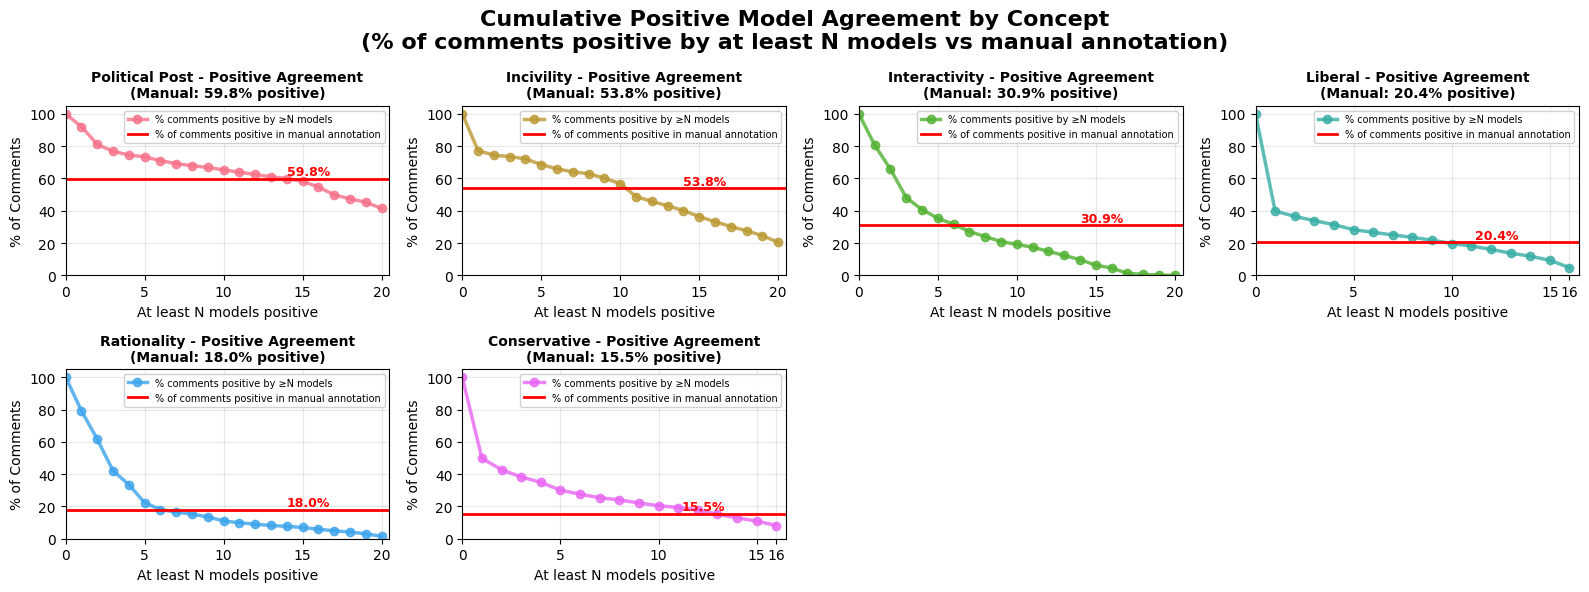

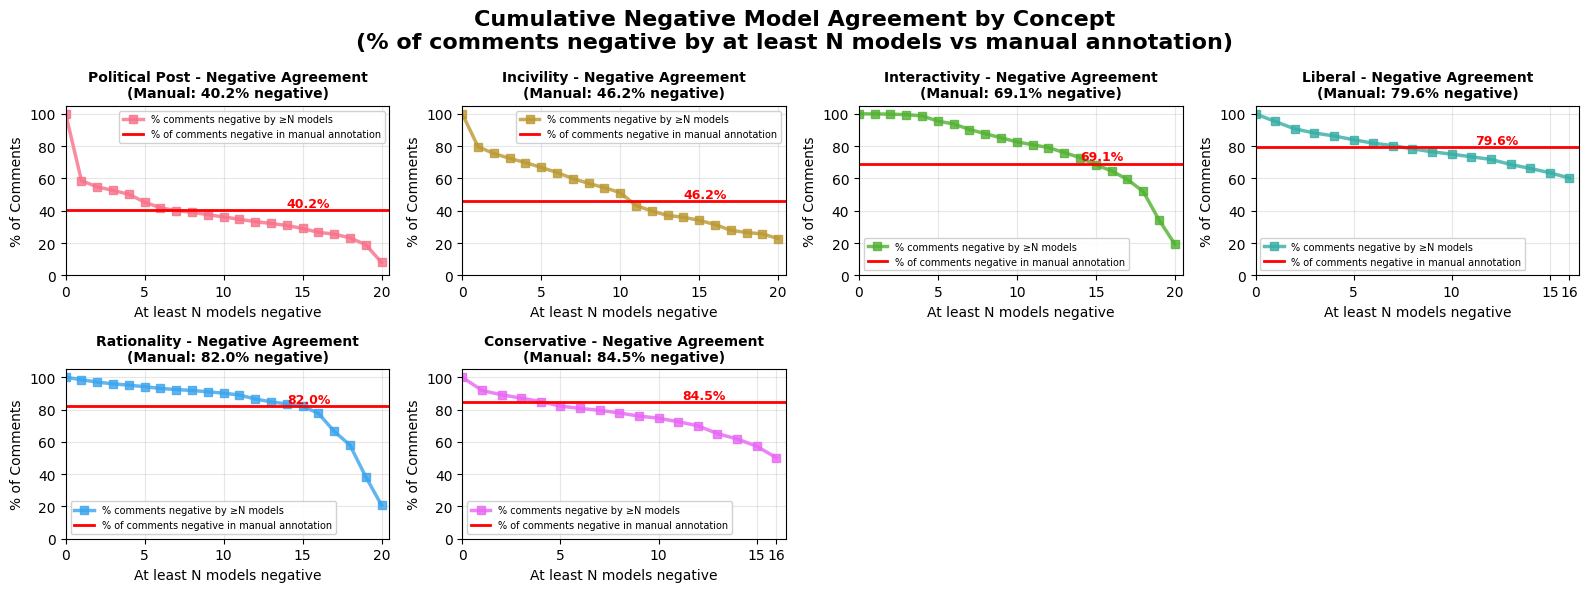

In [25]:
# Visualize model agreement distributions per concept with human prevalence reference

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_model_agreement_distributions():
    """
    Create individual distribution plots for each concept showing model agreement
    with human annotated prevalence as reference.
    """
    
    # Check if we have the required data
    if 'model_agreement_summary' not in globals():
        print("❌ Please run the analyze_model_positive_agreement() function first!")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Get unique concepts
    concepts = model_agreement_summary['concept'].unique()
    n_concepts = len(concepts)
    
    # Add human prevalence data
    human_prevalence = {}
    for concept_name, gt_col in boukes_concepts_info:
        if concept_name in concepts and gt_col in boukes2024.columns:
            total_comments = len(boukes2024[gt_col].dropna())
            gt_positive = boukes2024[gt_col].sum()
            prevalence = (gt_positive / total_comments * 100) if total_comments > 0 else 0
            human_prevalence[concept_name] = prevalence
    
    # Sort concepts by human prevalence
    concept_order = sorted(human_prevalence.keys(), key=lambda x: human_prevalence[x], reverse=True)
    
    # Individual distribution plots for each concept
    print("📊 Creating separate plots for positive and negative agreement...")
    
    # Calculate grid dimensions for positive plots
    n_cols = min(4, n_concepts)
    n_rows = (n_concepts + n_cols - 1) // n_cols
    
    # Create figure for POSITIVE agreement
    fig_pos, axes_pos = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    if n_concepts == 1:
        axes_pos = [axes_pos]
    else:
        axes_pos = axes_pos.flatten() if n_rows > 1 else axes_pos
    
    # Create figure for NEGATIVE agreement  
    fig_neg, axes_neg = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    if n_concepts == 1:
        axes_neg = [axes_neg]
    else:
        axes_neg = axes_neg.flatten() if n_rows > 1 else axes_neg

    for i, concept in enumerate(concept_order):
        if i >= len(axes_pos):
            break
            
        ax_pos = axes_pos[i] if n_concepts > 1 else axes_pos
        ax_neg = axes_neg[i] if n_concepts > 1 else axes_neg
        
        # Get data for this concept
        concept_data = model_agreement_summary[model_agreement_summary['concept'] == concept]
        
        # Calculate cumulative percentages
        cumulative_positive_data = []
        cumulative_negative_data = []
        max_models = concept_data['max_models'].iloc[0]
        
        for min_models in range(0, max_models + 1):
            # Sum percentages for min_models or more positive models
            cumulative_positive_pct = concept_data[concept_data['n_models_positive'] >= min_models]['percentage'].sum()
            cumulative_positive_data.append(cumulative_positive_pct)
            
            # Sum percentages for min_models or more negative models
            # (at least N models negative means at most (max_models - N) models positive)
            cumulative_negative_pct = concept_data[concept_data['n_models_positive'] <= (max_models - min_models)]['percentage'].sum()
            cumulative_negative_data.append(cumulative_negative_pct)
        
        x_values = range(0, max_models + 1)
        human_prev = human_prevalence[concept]
        human_neg = 100 - human_prev
        
        # === POSITIVE AGREEMENT PLOT ===
        ax_pos.plot(x_values, cumulative_positive_data, 
                   marker='o', 
                   linewidth=2.5,
                   markersize=6,
                   alpha=0.8,
                   color=sns.color_palette("husl", n_concepts)[i],
                   label='% comments positive by ≥N models')
        
        # Add human positive reference line
        ax_pos.axhline(y=human_prev, color='red', linestyle='-', linewidth=2, 
                      label='% of comments positive in manual annotation')
        
        # Add percentage label
        ax_pos.text(max_models * 0.7, human_prev + 2, f'{human_prev:.1f}%', 
                   color='red', fontweight='bold', fontsize=9)
        
        # Formatting for positive plot
        ax_pos.set_title(f'{concept} - Positive Agreement\n(Manual: {human_prev:.1f}% positive)', 
                        fontsize=10, fontweight='bold')
        ax_pos.set_xlabel('At least N models positive')
        ax_pos.set_ylabel('% of Comments')
        ax_pos.set_ylim(0, 105)
        ax_pos.set_xlim(0.5, max_models + 0.5)
        ax_pos.legend(fontsize=7, loc='best', framealpha=0.9)
        ax_pos.grid(True, alpha=0.3)
        
        # Set x-axis ticks
        x_tick_positions = [x for x in range(0, max_models + 1) if x % 5 == 0 or x == max_models]
        ax_pos.set_xticks(x_tick_positions)
        
        # === NEGATIVE AGREEMENT PLOT ===
        ax_neg.plot(x_values, cumulative_negative_data, 
                   marker='s', 
                   linewidth=2.5,
                   markersize=6,
                   alpha=0.8,
                   color=sns.color_palette("husl", n_concepts)[i],
                   label='% comments negative by ≥N models')
        
        # Add human negative reference line
        ax_neg.axhline(y=human_neg, color='red', linestyle='-', linewidth=2, 
                      label='% of comments negative in manual annotation')
        
        # Add percentage label
        ax_neg.text(max_models * 0.7, human_neg + 2, f'{human_neg:.1f}%', 
                   color='red', fontweight='bold', fontsize=9)
        
        # Formatting for negative plot
        ax_neg.set_title(f'{concept} - Negative Agreement\n(Manual: {human_neg:.1f}% negative)', 
                        fontsize=10, fontweight='bold')
        ax_neg.set_xlabel('At least N models negative')
        ax_neg.set_ylabel('% of Comments')
        ax_neg.set_ylim(0, 105)
        ax_neg.set_xlim(0.5, max_models + 0.5)
        ax_neg.legend(fontsize=7, loc='best', framealpha=0.9)
        ax_neg.grid(True, alpha=0.3)
        ax_neg.set_xticks(x_tick_positions)
    
    # Hide empty subplots
    for i in range(n_concepts, len(axes_pos)):
        axes_pos[i].set_visible(False)
        axes_neg[i].set_visible(False)
    
    # Set titles for each figure
    fig_pos.suptitle('Cumulative Positive Model Agreement by Concept\n(% of comments positive by at least N models vs manual annotation)', 
                     fontsize=16, fontweight='bold', y=0.98)
    fig_neg.suptitle('Cumulative Negative Model Agreement by Concept\n(% of comments negative by at least N models vs manual annotation)', 
                     fontsize=16, fontweight='bold', y=0.98)
    
    fig_pos.tight_layout()
    fig_neg.tight_layout()
    plt.show()  

# Run the visualization
if 'model_agreement_summary' in globals():
    visualize_model_agreement_distributions()
else:
    print("❌ Please run the analyze_model_positive_agreement() function first!")

## Cumulative plots for disagreement

📊 Creating model disagreement plots...


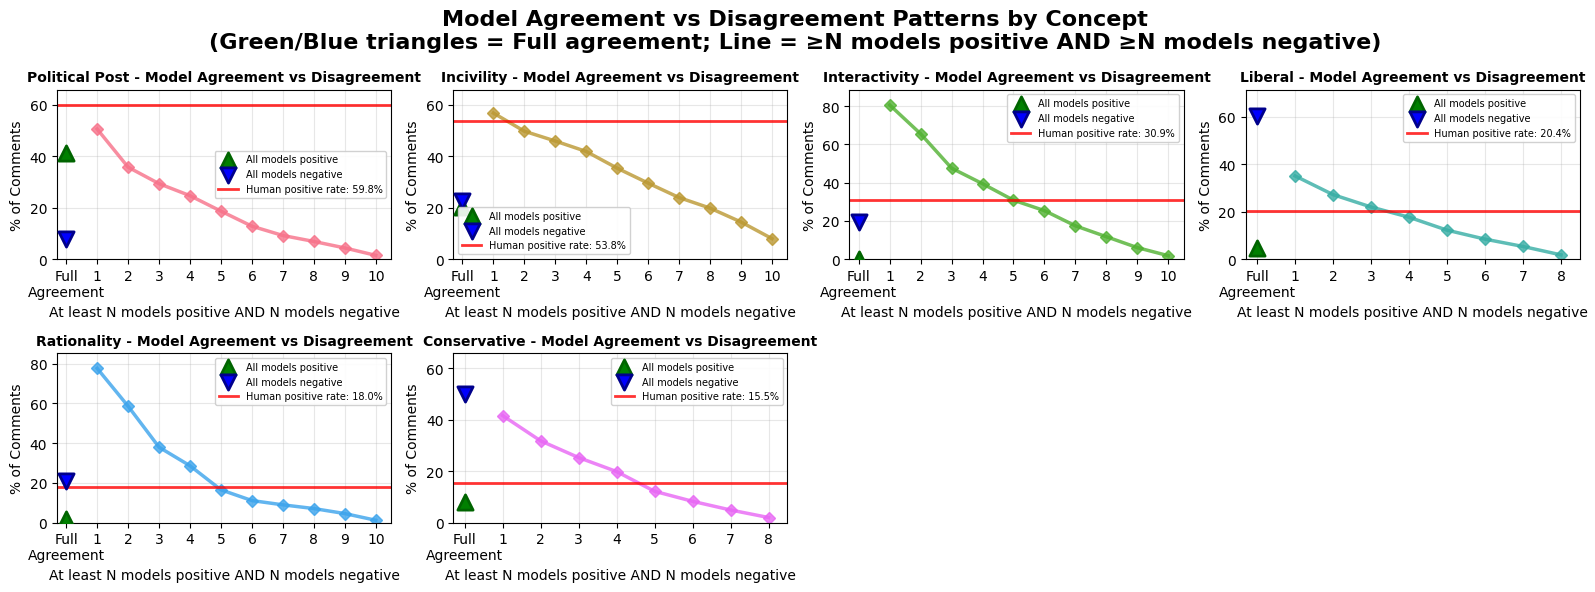

In [26]:
# Visualize model disagreement patterns per concept

def visualize_model_disagreement():
    """
    Create plots showing disagreement among models - the percentage of comments where
    at least N models say positive AND at least N models say negative simultaneously.
    """
    
    # Check if we have the required data
    if 'model_agreement_summary' not in globals():
        print("❌ Please run the analyze_model_positive_agreement() function first!")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Get unique concepts
    concepts = model_agreement_summary['concept'].unique()
    n_concepts = len(concepts)
    
    # Add human prevalence data
    human_prevalence = {}
    for concept_name, gt_col in boukes_concepts_info:
        if concept_name in concepts and gt_col in boukes2024.columns:
            total_comments = len(boukes2024[gt_col].dropna())
            gt_positive = boukes2024[gt_col].sum()
            prevalence = (gt_positive / total_comments * 100) if total_comments > 0 else 0
            human_prevalence[concept_name] = prevalence
    
    # Sort concepts by human prevalence
    concept_order = sorted(human_prevalence.keys(), key=lambda x: human_prevalence[x], reverse=True)
    
    print("📊 Creating model disagreement plots...")
    
    # Calculate grid dimensions
    n_cols = min(4, n_concepts)
    n_rows = (n_concepts + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    if n_concepts == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes

    for i, concept in enumerate(concept_order):
        if i >= len(axes):
            break
            
        ax = axes[i] if n_concepts > 1 else axes
        
        # Get data for this concept
        concept_data = model_agreement_summary[model_agreement_summary['concept'] == concept]
        max_models = concept_data['max_models'].iloc[0]
        
        # Determine max disagreement level based on concept
        if concept.lower() in ['liberal', 'conservative']:
            max_disagreement_level = min(8, max_models // 2)
        else:
            max_disagreement_level = min(10, max_models // 2)
        
        # Calculate disagreement and agreement data
        disagreement_data = []
        agreement_data = []
        x_values = range(0, max_disagreement_level + 1)  # Start from 0 to include full agreement
        
        for min_each_side in x_values:
            if min_each_side == 0:
                # Calculate full positive agreement (all models positive)
                full_positive_pct = 0
                # Calculate full negative agreement (all models negative)  
                full_negative_pct = 0
                
                for _, row in concept_data.iterrows():
                    n_positive = row['n_models_positive']
                    n_negative = max_models - n_positive
                    
                    # Full positive agreement means all models say positive (n_negative = 0)
                    if n_negative == 0:
                        full_positive_pct += row['percentage']
                    # Full negative agreement means all models say negative (n_positive = 0)
                    elif n_positive == 0:
                        full_negative_pct += row['percentage']
                
                disagreement_data.append(0)  # No disagreement when we require 0 models each side
                agreement_data.append(full_positive_pct + full_negative_pct)  # Total agreement
                full_pos_agreement = full_positive_pct
                full_neg_agreement = full_negative_pct
            else:
                # Find comments where at least min_each_side models say positive 
                # AND at least min_each_side models say negative
                disagreement_pct = 0
                
                for _, row in concept_data.iterrows():
                    n_positive = row['n_models_positive']
                    n_negative = max_models - n_positive
                    
                    # Check if this distribution meets our disagreement criteria
                    if n_positive >= min_each_side and n_negative >= min_each_side:
                        disagreement_pct += row['percentage']
                
                disagreement_data.append(disagreement_pct)
                agreement_data.append(0)  # No full agreement for disagreement levels > 0
        
        # Create line plots
        # Disagreement line (without label to remove from legend)
        disagreement_line = ax.plot(x_values[1:], disagreement_data[1:], 
                                   marker='D', linewidth=2.5, markersize=6, alpha=0.8,
                                   color=sns.color_palette("husl", n_concepts)[i])
        
        # Full agreement points (separate values, not combined)
        positive_agreement_point = ax.scatter([0], [full_pos_agreement], 
                                            marker='^', s=120, 
                                            color='green', edgecolor='darkgreen', linewidth=2,
                                            label=f'All models positive', 
                                            zorder=5)
        
        # Full negative agreement point (separate value)
        negative_agreement_point = ax.scatter([0], [full_neg_agreement], 
                                            marker='v', s=120, 
                                            color='blue', edgecolor='darkblue', linewidth=2,
                                            label=f'All models negative', 
                                            zorder=5)
        
        human_prev = human_prevalence[concept]
        human_neg = 100 - human_prev
        
        # Add human prevalence reference line
        ax.axhline(y=human_prev, color='red', linestyle='-', linewidth=2, alpha=0.8,
                  label=f'Human positive rate: {human_prev:.1f}%')
        
        ax.set_title(f'{concept} - Model Agreement vs Disagreement', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('At least N models positive AND N models negative')
        ax.set_ylabel('% of Comments')
        
        # Adjust y-axis to accommodate both agreement and disagreement
        max_y = max(max(disagreement_data) if disagreement_data else 0, 
                   max(agreement_data) if agreement_data else 0, 60)
        ax.set_ylim(0, max_y * 1.1)
        ax.set_xlim(-0.3, max_disagreement_level + 0.5)
        ax.legend(fontsize=7, loc='best', framealpha=0.9)
        ax.grid(True, alpha=0.3)
        
        # Set x-axis ticks to include agreement points
        ax.set_xticks([0] + list(range(1, max_disagreement_level + 1)))
        ax.set_xticklabels(['Full\nAgreement'] + [str(i) for i in range(1, max_disagreement_level + 1)])
        
        # Remove value labels (as requested)
    
    # Hide empty subplots
    for i in range(n_concepts, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Model Agreement vs Disagreement Patterns by Concept\n(Green/Blue triangles = Full agreement; Line = ≥N models positive AND ≥N models negative)', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    return True

# Run the disagreement visualization
if 'model_agreement_summary' in globals():
    visualize_model_disagreement()
else:
    print("❌ Please run the analyze_model_positive_agreement() function first!")

# add a benchmark cumulative distribution to the plots by random errors of the human annotations

## Calculate the modal-model annotation across the zero temperature, 5 prompts for 4 models per concept

In [24]:
# Calculate modal-model annotation across zero temperature, 5 prompts for 4 models per concept
print("Calculating modal-model annotations for each concept...")

# Create labels dictionary for all model columns
labels_dict = {}
for col in model_columns_allprompts:
    labels_dict[col] = get_labels(col)

# Process each concept
for concept_name, human_gt_col in boukes_concepts_info:
    print(f"\nProcessing concept: {concept_name}")
    
    # Get all model columns for this concept at zero temperature
    concept_model_cols = [col for col in model_columns_allprompts 
                         if labels_dict[col]['concept'] == concept_name 
                         and labels_dict[col]['temperature'] == 'Zero: 0.0']
    
    print(f"Found {len(concept_model_cols)} model columns for {concept_name}")
    
    if len(concept_model_cols) == 0:
        print(f"No zero temperature columns found for {concept_name}")
        continue
    
    # Calculate modal annotation for each row
    modal_annotations = []
    
    for idx, row in boukes2024.iterrows():
        # Get predictions from all models for this row
        predictions = []
        for col in concept_model_cols:
            if not pd.isna(row[col]):
                predictions.append(row[col])
        
        if len(predictions) == 0:
            # No valid predictions
            modal_annotations.append(np.nan)
        else:
            # Calculate mode
            from collections import Counter
            vote_counts = Counter(predictions)
            
            # Get the most common prediction(s)
            max_count = max(vote_counts.values())
            modes = [pred for pred, count in vote_counts.items() if count == max_count]
            
            if len(modes) == 1:
                # Clear winner
                modal_annotations.append(modes[0])
            else:
                # Tie - use human annotation as tiebreaker
                human_annotation = row[human_gt_col]
                if human_annotation in modes:
                    modal_annotations.append(human_annotation)
                else:
                    # Human annotation not in tie, use first mode
                    modal_annotations.append(modes[0])
    
    # Add modal annotation column to boukes2024 using .loc to avoid warning
    modal_col_name = f"{concept_name}_20model_zero_mode"
    boukes2024.loc[:, modal_col_name] = modal_annotations
    
    print(f"Created column: {modal_col_name}")
    print(f"Modal annotation distribution:")
    print(boukes2024[modal_col_name].value_counts(dropna=False))

print("\nModal-model annotation calculation completed!")

Calculating modal-model annotations for each concept...

Processing concept: Incivility
Found 20 model columns for Incivility
Created column: Incivility_20model_zero_mode
Modal annotation distribution:
Incivility_20model_zero_mode
1    1311
0    1148
Name: count, dtype: int64

Processing concept: Rationality
Found 20 model columns for Rationality
Created column: Rationality_20model_zero_mode
Modal annotation distribution:
Rationality_20model_zero_mode
0    2206
1     253
Name: count, dtype: int64

Processing concept: Interactivity
Found 20 model columns for Interactivity
Created column: Interactivity_20model_zero_mode
Modal annotation distribution:
Interactivity_20model_zero_mode
0    2004
1     455
Name: count, dtype: int64

Processing concept: Liberal
Found 16 model columns for Liberal
Created column: Liberal_20model_zero_mode
Modal annotation distribution:
Liberal_20model_zero_mode
0    1908
1     551
Name: count, dtype: int64

Processing concept: Conservative
Found 16 model columns

## significance test multimodel_mode vs human annotation per concept

In [10]:
# Statistical significance tests for 20model_mode vs human annotations (Clean Summary)
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score
import pandas as pd
import numpy as np

print("Statistical Tests: 20model_mode vs Human Annotations")
print("="*55)

# Find all modal annotation columns
modal_columns = [col for col in boukes2024.columns if col.endswith('_20model_zero_mode')]

results_summary = []

for modal_col in modal_columns:
    # Extract concept name
    concept_name = modal_col.replace('_20model_zero_mode', '')
    
    # Find corresponding human annotation column
    human_col = None
    for concept, gt_col in boukes_concepts_info:
        if concept == concept_name:
            human_col = gt_col
            break
    
    if human_col is None:
        continue
    
    # Get data without missing values
    data = boukes2024[[modal_col, human_col]].dropna()
    
    if len(data) == 0:
        continue
    
    modal_pred = data[modal_col]
    human_true = data[human_col]
    
    # Calculate metrics
    n_samples = len(data)
    accuracy = accuracy_score(human_true, modal_pred)
    kappa = cohen_kappa_score(human_true, modal_pred)
    macro_f1 = f1_score(human_true, modal_pred, average='macro')
    
    # Statistical test
    contingency_2x2 = pd.crosstab(human_true, modal_pred)
    
    fisher_p = None
    chi2_p = None
    
    if contingency_2x2.shape == (2, 2):
        # Fisher's exact test
        try:
            table_array = contingency_2x2.values
            odds_ratio, fisher_p = fisher_exact(table_array)
        except:
            pass
        
        # Chi-square test
        try:
            chi2_stat, chi2_p, dof, expected = chi2_contingency(contingency_2x2)
        except:
            pass
    
    # Store results for summary
    results_summary.append({
        'Concept': concept_name,
        'Sample_Size': n_samples,
        'Accuracy': accuracy,
        'Cohens_Kappa': kappa,
        'Macro_F1': macro_f1,
        'Chi2_p_value': chi2_p,
        'Fisher_p_value': fisher_p
    })

# Create and display summary table
summary_df = pd.DataFrame(results_summary)
summary_df = summary_df.round(4)

print(summary_df.to_string(index=False))

# Save summary to a variable for potential further analysis
modal_vs_human_test_results = summary_df

Statistical Tests: 20model_mode vs Human Annotations
       Concept  Sample_Size  Accuracy  Cohens_Kappa  Macro_F1  Chi2_p_value  Fisher_p_value
    Incivility         2459    0.8223        0.6428    0.8214           0.0             0.0
   Rationality         2459    0.8585        0.4246    0.7088           0.0             0.0
 Interactivity         2459    0.8154        0.5135    0.7517           0.0             0.0
       Liberal         2459    0.8646        0.5978    0.7988           0.0             0.0
  Conservative         2459    0.8756        0.5988    0.7978           0.0             0.0
Political Post         2459    0.8426        0.6661    0.8327           0.0             0.0


# Create simulated consensus scores based on modal annotations (20-model mode) instead of human labels

In [22]:
# Create simulated consensus scores with TWO SETS of simulations per concept
import numpy as np
import pandas as pd
from collections import Counter

print("Creating TWO SETS of simulated consensus scores...")
print("Set 1: Based on manual annotations (ground truth)")
print("Set 2: Based on modal annotations (20-model mode)")

# Get modal columns (mode per concept stored in columns ending with '_20model_zero_mode')
modal_columns = [col for col in boukes2024.columns if col.endswith('_20model_zero_mode')]
print(f"Found modal columns: {modal_columns}")

# Create labels dictionary for all model columns
labels_dict = {}
for col in model_columns_allprompts:
    labels_dict[col] = get_labels(col)

# Store results for simulated analysis - TWO SETS VERSION
simulated_agreement_matrix_20model_mode = None
simulated_consensus_results_20model_mode = {}
simulated_consensus_summary_data_20model_mode = []

# Store simulated agreement matrices like the human annotation analysis
simulated_posagreement_matrix_all_20model_mode = {}
simulated_negagreement_matrix_all_20model_mode = {}
simulated_agreement_counts_all_20model_mode = {}

# Process each modal column
for modal_col in modal_columns:
    # Extract concept name from modal column name
    concept_name = modal_col.replace('_20model_zero_mode', '')
    print(f"Processing {concept_name} based on modal column {modal_col}...")
    
    # Get the corresponding ground truth (manual annotation) column
    try:
        gt_col = get_ground_truth_col(concept_name)
        print(f"  Manual annotation column: {gt_col}")
    except ValueError:
        print(f"  No manual annotation column found for {concept_name}, skipping...")
        continue
    
    # Determine number of simulations based on concept type
    if concept_name.lower() in ['liberal', 'conservative']:
        n_simulations = 16
        print(f"  Processing {concept_name} with {n_simulations} simulations...")
    else:
        n_simulations = 20
        print(f"  Processing {concept_name} with {n_simulations} simulations...")
    
    # Get all model columns for this concept at zero temperature
    concept_model_cols = [col for col in model_columns_allprompts 
                         if labels_dict[col]['concept'] == concept_name 
                         and labels_dict[col]['temperature'] == 'Zero: 0.0']
    
    if len(concept_model_cols) == 0:
        print(f"  No zero temperature columns found for {concept_name}")
        continue
    
    # Calculate accuracy of modal annotation vs manual annotation (ground truth)
    # This is the target accuracy we want to match
    valid_mask = boukes2024[modal_col].notna() & boukes2024[gt_col].notna()
    if valid_mask.sum() == 0:
        print(f"  No valid observations for {concept_name}")
        continue
    
    modal_vs_manual_accuracy = (boukes2024.loc[valid_mask, modal_col] == boukes2024.loc[valid_mask, gt_col]).mean()
    error_rate = 1 - modal_vs_manual_accuracy
    print(f"  Modal vs Manual accuracy: {modal_vs_manual_accuracy:.3f}, Error rate: {error_rate:.3f}")
    
    # Get manual and modal annotations for valid observations
    manual_annotations = boukes2024.loc[valid_mask, gt_col]
    modal_annotations = boukes2024.loc[valid_mask, modal_col]
    n_samples = len(manual_annotations)
    
    if n_samples == 0:
        continue
    
    # Create 2 * n_simulations simulated models:
    # - First n_simulations: based on manual annotations
    # - Second n_simulations: based on modal annotations
    all_sim_cols = ([f'simulated_manual_{concept_name}_{i+1}' for i in range(n_simulations)] + 
                   [f'simulated_modal_{concept_name}_{i+1}' for i in range(n_simulations)])
    
    concept_agreement_matrix = pd.DataFrame(index=manual_annotations.index, 
                                          columns=all_sim_cols)
    
    # Initialize or extend the global agreement matrix
    if simulated_agreement_matrix_20model_mode is None:
        simulated_agreement_matrix_20model_mode = concept_agreement_matrix.copy()
    else:
        # Add the concept-specific columns to the global matrix
        simulated_agreement_matrix_20model_mode = simulated_agreement_matrix_20model_mode.join(
            concept_agreement_matrix, how='outer'
        )
    
    # SET 1: Create simulations based on manual annotations
    print(f"  Creating Set 1: {n_simulations} simulations based on manual annotations")
    for model_idx in range(n_simulations):
        # Create simulated model predictions by flipping manual annotations
        simulated_model_preds = manual_annotations.copy()
        
        # Randomly select indices to flip to match the error rate
        n_to_flip = int(n_samples * error_rate)
        flip_indices = np.random.choice(simulated_model_preds.index, size=n_to_flip, replace=False)
        
        # Flip the selected labels (0->1, 1->0)
        simulated_model_preds.loc[flip_indices] = 1 - simulated_model_preds.loc[flip_indices]
        
        # Calculate agreement with manual annotations (1 for agree, 0 for disagree)
        col_name = f'simulated_manual_{concept_name}_{model_idx+1}'
        concept_agreement_matrix[col_name] = (
            simulated_model_preds == manual_annotations
        ).astype(int)
        
        # Also update the global matrix
        simulated_agreement_matrix_20model_mode[col_name] = concept_agreement_matrix[col_name]
    
    # SET 2: Create simulations based on modal annotations (similar to original code)
    print(f"  Creating Set 2: {n_simulations} simulations based on modal annotations")
    for model_idx in range(n_simulations):
        # Create simulated model predictions by flipping modal annotations
        simulated_model_preds = modal_annotations.copy()
        
        # Randomly select indices to flip to match the error rate
        n_to_flip = int(n_samples * error_rate)
        flip_indices = np.random.choice(simulated_model_preds.index, size=n_to_flip, replace=False)
        
        # Flip the selected labels (0->1, 1->0)
        simulated_model_preds.loc[flip_indices] = 1 - simulated_model_preds.loc[flip_indices]
        
        # Calculate agreement with manual annotations (1 for agree, 0 for disagree)
        col_name = f'simulated_modal_{concept_name}_{model_idx+1}'
        concept_agreement_matrix[col_name] = (
            simulated_model_preds == manual_annotations
        ).astype(int)
        
        # Also update the global matrix
        simulated_agreement_matrix_20model_mode[col_name] = concept_agreement_matrix[col_name]
    
    # Create positive and negative agreement matrices (based on manual annotations)
    pos_idx = manual_annotations == 1
    neg_idx = manual_annotations == 0
    
    simulated_posagreement_matrix_all_20model_mode[concept_name] = concept_agreement_matrix[pos_idx]
    simulated_negagreement_matrix_all_20model_mode[concept_name] = concept_agreement_matrix[neg_idx]
    
    # Count positive and negative agreements per comment
    pos_agreements = concept_agreement_matrix[pos_idx].sum(axis=1) if pos_idx.sum() > 0 else pd.Series(dtype=int)
    neg_agreements = concept_agreement_matrix[neg_idx].sum(axis=1) if neg_idx.sum() > 0 else pd.Series(dtype=int)
    total_agreements = concept_agreement_matrix.sum(axis=1)
    
    # Combine counts into a single DataFrame (matching the human annotation analysis structure)
    combined_counts = pd.DataFrame({
        'Total Agreements': total_agreements
    })
    
    if len(pos_agreements) > 0:
        combined_counts = combined_counts.join(
            pd.DataFrame({'Positive Agreements': pos_agreements}), 
            how='outer'
        )
    else:
        combined_counts['Positive Agreements'] = 0
        
    if len(neg_agreements) > 0:
        combined_counts = combined_counts.join(
            pd.DataFrame({'Negative Agreements': neg_agreements}), 
            how='outer'
        )
    else:
        combined_counts['Negative Agreements'] = 0
    
    # Fill NaN values with 0
    combined_counts = combined_counts.fillna(0)
    
    # Store the counts for this concept
    simulated_agreement_counts_all_20model_mode[concept_name] = combined_counts
    
    # Calculate consensus statistics for summary (based on manual annotations)
    total_observations = len(manual_annotations)
    
    # Count different types of consensus based on model agreements with manual annotations
    identical_positive_correct = 0
    identical_negative_correct = 0
    identical_positive_incorrect = 0
    identical_negative_incorrect = 0
    partial_consensus = 0
    
    # For each comment, check if all simulated models agree with manual annotation
    for idx in manual_annotations.index:
        try:
            manual_true = manual_annotations.loc[idx]
            # Get predictions from all simulated models (both sets)
            model_agreements = concept_agreement_matrix.loc[idx].values
            
            # Count how many models agree with manual annotation
            n_agree = model_agreements.sum()
            total_sims = 2 * n_simulations  # Both sets combined
            
            # If all models agree with manual (either all correct or all incorrect)
            if n_agree == total_sims:  # All models agree with manual
                if manual_true == 1:
                    identical_positive_correct += 1
                else:
                    identical_negative_correct += 1
            elif n_agree == 0:  # All models disagree with manual
                if manual_true == 1:
                    identical_negative_incorrect += 1  # Manual says positive, all models say negative
                else:
                    identical_positive_incorrect += 1  # Manual says negative, all models say positive
            else:
                # Some models agree, some disagree
                partial_consensus += 1
                
        except (KeyError, IndexError):
            continue
    
    # Store consensus results in the same format as the human annotation analysis
    simulated_consensus_results_20model_mode[concept_name] = {
        'identical_positive_correct': identical_positive_correct,
        'identical_negative_correct': identical_negative_correct,
        'identical_positive_incorrect': identical_positive_incorrect,
        'identical_negative_incorrect': identical_negative_incorrect,
        'partial_consensus': partial_consensus,
        'total_observations': total_observations,
        'n_simulations': 2 * n_simulations  # Store the total number of simulations (both sets)
    }
    
    # Calculate percentages
    identical_correct = identical_positive_correct + identical_negative_correct
    identical_incorrect = identical_positive_incorrect + identical_negative_incorrect
    
    # Store results for this concept
    simulated_consensus_summary_data_20model_mode.append({
        'Concept': concept_name,
        'N_Simulations': 2 * n_simulations,  # Total simulations (both sets)
        'N_Manual_Sims': n_simulations,  # Set 1: manual-based
        'N_Modal_Sims': n_simulations,   # Set 2: modal-based
        'Total_Observations': total_observations,
        'Identical_Correct': identical_correct,
        'Identical_Incorrect': identical_incorrect,
        'Partial_Consensus': partial_consensus,
        'Identical_Correct_Pct': (identical_correct/total_observations*100) if total_observations > 0 else 0,
        'Identical_Incorrect_Pct': (identical_incorrect/total_observations*100) if total_observations > 0 else 0,
        'Partial_Consensus_Pct': (partial_consensus/total_observations*100) if total_observations > 0 else 0,
        'Pos_Correct': identical_positive_correct,
        'Neg_Correct': identical_negative_correct,
        'Pos_Incorrect': identical_positive_incorrect,
        'Neg_Incorrect': identical_negative_incorrect,
        'Modal_vs_Manual_Accuracy': modal_vs_manual_accuracy,
        'Error_Rate_Used': error_rate
    })

# Create DataFrame for simulated results (two-sets version)
simulated_consensus_df_20model_mode = pd.DataFrame(simulated_consensus_summary_data_20model_mode)

print(f"✅ TWO-SETS Simulation complete: {len(simulated_consensus_df_20model_mode)} concepts processed")
print(f"📊 Data structures created with agreement counts per comment for positive/negative annotations")
print(f"🎯 Output compatible with analyze_model_positive_agreement() structure")
print(f"🔢 Liberal/Conservative concepts: 2×16 simulations, Other concepts: 2×20 simulations")
print(f"🔄 Set 1: Based on manual annotations, Set 2: Based on modal annotations")
print(f"🎯 Both sets target the same accuracy as modal vs manual annotation per concept")

Creating TWO SETS of simulated consensus scores...
Set 1: Based on manual annotations (ground truth)
Set 2: Based on modal annotations (20-model mode)
Found modal columns: ['Incivility_20model_zero_mode', 'Rationality_20model_zero_mode', 'Interactivity_20model_zero_mode', 'Liberal_20model_zero_mode', 'Conservative_20model_zero_mode', 'Political Post_20model_zero_mode']
Processing Incivility based on modal column Incivility_20model_zero_mode...
  Manual annotation column: INCIVILITY_DUMMY
  Processing Incivility with 20 simulations...
  Modal vs Manual accuracy: 0.822, Error rate: 0.178
  Creating Set 1: 20 simulations based on manual annotations
  Creating Set 2: 20 simulations based on modal annotations
Processing Rationality based on modal column Rationality_20model_zero_mode...
  Manual annotation column: RATIONALITY_DUMMY
  Processing Rationality with 20 simulations...
  Modal vs Manual accuracy: 0.858, Error rate: 0.142
  Creating Set 1: 20 simulations based on manual annotations


In [12]:
# Display summary of MODE-BASED simulated consensus analysis
print("="*80)
print("TWO-SETS SIMULATED CONSENSUS ANALYSIS SUMMARY")
print("="*80)

# Calculate comprehensive metrics for the summary table
summary_table_data_20model_mode = []

for concept_name in simulated_consensus_df_20model_mode['Concept'].unique():
    concept_data = simulated_consensus_df_20model_mode[simulated_consensus_df_20model_mode['Concept'] == concept_name].iloc[0]
    
    # Get the human annotation column for this concept
    try:
        human_col = get_ground_truth_col(concept_name)
    except ValueError:
        human_col = "N/A"
        continue
    
    # Get modal column name
    modal_col_name = f"{concept_name}_20model_zero_mode"
    
    # Get number of included model columns for this concept
    concept_model_cols = [col for col in model_columns_allprompts 
                         if labels_dict[col]['concept'] == concept_name 
                         and labels_dict[col]['temperature'] == 'Zero: 0.0']
    n_model_cols = len(concept_model_cols)
    
    # Get valid observations for this concept
    if human_col in boukes2024.columns and modal_col_name in boukes2024.columns:
        valid_mask = boukes2024[human_col].notna() & boukes2024[modal_col_name].notna()
        n_comments = valid_mask.sum()
        
        if n_comments > 0:
            # Get human and modal annotations
            human_annotations = boukes2024.loc[valid_mask, human_col]
            modal_annotations = boukes2024.loc[valid_mask, modal_col_name]
            
            # Get simulation columns for this concept
            manual_sim_cols = [col for col in simulated_agreement_matrix_20model_mode.columns 
                              if col.startswith(f'simulated_manual_{concept_name}_')]
            modal_sim_cols = [col for col in simulated_agreement_matrix_20model_mode.columns 
                             if col.startswith(f'simulated_modal_{concept_name}_')]
            
            n_manual_sims = len(manual_sim_cols)
            n_modal_sims = len(modal_sim_cols)
            
            # Calculate accuracies for manual simulations
            manual_vs_human_accuracies = []
            manual_vs_modal_accuracies = []
            
            for sim_col in manual_sim_cols:
                if sim_col in simulated_agreement_matrix_20model_mode.columns:
                    sim_mask = simulated_agreement_matrix_20model_mode[sim_col].notna()
                    combined_mask = valid_mask & sim_mask
                    
                    if combined_mask.sum() > 0:
                        # Manual sim accuracy vs human annotations
                        # Agreement column shows 1 for agree, 0 for disagree with human
                        manual_vs_human_acc = simulated_agreement_matrix_20model_mode.loc[combined_mask, sim_col].mean()
                        manual_vs_human_accuracies.append(manual_vs_human_acc)
                        
                        # Manual sim accuracy vs modal annotations
                        # Need to reconstruct the actual simulation predictions
                        # Since agreement with human = (sim_pred == human), we can get sim_pred
                        sim_agreements = simulated_agreement_matrix_20model_mode.loc[combined_mask, sim_col]
                        human_vals = boukes2024.loc[combined_mask, human_col]
                        modal_vals = boukes2024.loc[combined_mask, modal_col_name]
                        
                        # Reconstruct simulation predictions: sim_pred = human if agree else 1-human
                        sim_preds = human_vals.copy()
                        disagree_mask = sim_agreements == 0
                        sim_preds.loc[disagree_mask] = 1 - sim_preds.loc[disagree_mask]
                        
                        # Calculate accuracy vs modal
                        manual_vs_modal_acc = (sim_preds == modal_vals).mean()
                        manual_vs_modal_accuracies.append(manual_vs_modal_acc)
            
            # Calculate accuracies for modal simulations
            modal_vs_human_accuracies = []
            modal_vs_modal_accuracies = []
            
            for sim_col in modal_sim_cols:
                if sim_col in simulated_agreement_matrix_20model_mode.columns:
                    sim_mask = simulated_agreement_matrix_20model_mode[sim_col].notna()
                    combined_mask = valid_mask & sim_mask
                    
                    if combined_mask.sum() > 0:
                        # Modal sim accuracy vs human annotations
                        modal_vs_human_acc = simulated_agreement_matrix_20model_mode.loc[combined_mask, sim_col].mean()
                        modal_vs_human_accuracies.append(modal_vs_human_acc)
                        
                        # Modal sim accuracy vs modal annotations
                        # Reconstruct simulation predictions
                        sim_agreements = simulated_agreement_matrix_20model_mode.loc[combined_mask, sim_col]
                        human_vals = boukes2024.loc[combined_mask, human_col]
                        modal_vals = boukes2024.loc[combined_mask, modal_col_name]
                        
                        # Reconstruct simulation predictions: sim_pred = human if agree else 1-human
                        sim_preds = human_vals.copy()
                        disagree_mask = sim_agreements == 0
                        sim_preds.loc[disagree_mask] = 1 - sim_preds.loc[disagree_mask]
                        
                        # Calculate accuracy vs modal
                        modal_vs_modal_acc = (sim_preds == modal_vals).mean()
                        modal_vs_modal_accuracies.append(modal_vs_modal_acc)
            
            # Calculate means
            mean_manual_vs_human = np.mean(manual_vs_human_accuracies) if manual_vs_human_accuracies else 0
            mean_manual_vs_modal = np.mean(manual_vs_modal_accuracies) if manual_vs_modal_accuracies else 0
            mean_modal_vs_human = np.mean(modal_vs_human_accuracies) if modal_vs_human_accuracies else 0
            mean_modal_vs_modal = np.mean(modal_vs_modal_accuracies) if modal_vs_modal_accuracies else 0
            
        else:
            n_comments = 0
            n_manual_sims = 0
            n_modal_sims = 0
            mean_manual_vs_human = 0
            mean_manual_vs_modal = 0
            mean_modal_vs_human = 0
            mean_modal_vs_modal = 0
    else:
        n_comments = 0
        n_manual_sims = 0
        n_modal_sims = 0
        mean_manual_vs_human = 0
        mean_manual_vs_modal = 0
        mean_modal_vs_human = 0
        mean_modal_vs_modal = 0
    
    summary_table_data_20model_mode.append({
        'Concept': concept_name,
        'Human Annotation Column': human_col,
        'Number of Comments': n_comments,
        'Number of Model Columns': n_model_cols,
        'Manual Simulations': n_manual_sims,
        'Manual vs Human Acc': f"{mean_manual_vs_human:.3f}",
        'Manual vs Modal Acc': f"{mean_manual_vs_modal:.3f}",
        'Modal Simulations': n_modal_sims,
        'Modal vs Human Acc': f"{mean_modal_vs_human:.3f}",
        'Modal vs Modal Acc': f"{mean_modal_vs_modal:.3f}"
    })

# Create the summary table
summary_table_20model_mode = pd.DataFrame(summary_table_data_20model_mode)

# Display the table
print("\n📊 COMPREHENSIVE SIMULATION SUMMARY TABLE")
print("─" * 140)
print(summary_table_20model_mode.to_string(index=False, max_colwidth=25))

print("\n\n📋 COLUMN EXPLANATIONS:")
print("• Concept: The annotation concept being analyzed")
print("• Human Annotation Column: The ground truth column from boukes_concepts_info")
print("• Number of Comments: Total comments with valid human and modal annotations")
print("• Number of Model Columns: Model prediction columns at zero temperature for this concept")
print("• Manual Simulations: Number of simulations based on manual annotations")
print("• Manual vs Human Acc: Mean accuracy of manual-based simulations vs human annotations")
print("• Manual vs Modal Acc: Mean accuracy of manual-based simulations vs modal annotations")
print("• Modal Simulations: Number of simulations based on modal annotations")
print("• Modal vs Human Acc: Mean accuracy of modal-based simulations vs human annotations")
print("• Modal vs Modal Acc: Mean accuracy of modal-based simulations vs modal annotations")
print("\n🎯 Both simulation sets target the same error rate based on modal vs human accuracy")
print("🔄 Liberal/Conservative: 16 sims each set, Others: 20 sims each set")

TWO-SETS SIMULATED CONSENSUS ANALYSIS SUMMARY

📊 COMPREHENSIVE SIMULATION SUMMARY TABLE
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Concept Human Annotation Column  Number of Comments  Number of Model Columns  Manual Simulations Manual vs Human Acc Manual vs Modal Acc  Modal Simulations Modal vs Human Acc Modal vs Modal Acc
    Incivility        INCIVILITY_DUMMY                2459                       20                  20               0.823               0.707                 20              0.709              0.823
   Rationality       RATIONALITY_DUMMY                2459                       20                  20               0.858               0.757                 20              0.757              0.858
 Interactivity     INTERACTIVITY_DUMMY                2459                       20                  20               0.816               0.700                 20      

## Use the simulated data as benchmarks for the cumulative agreement plots

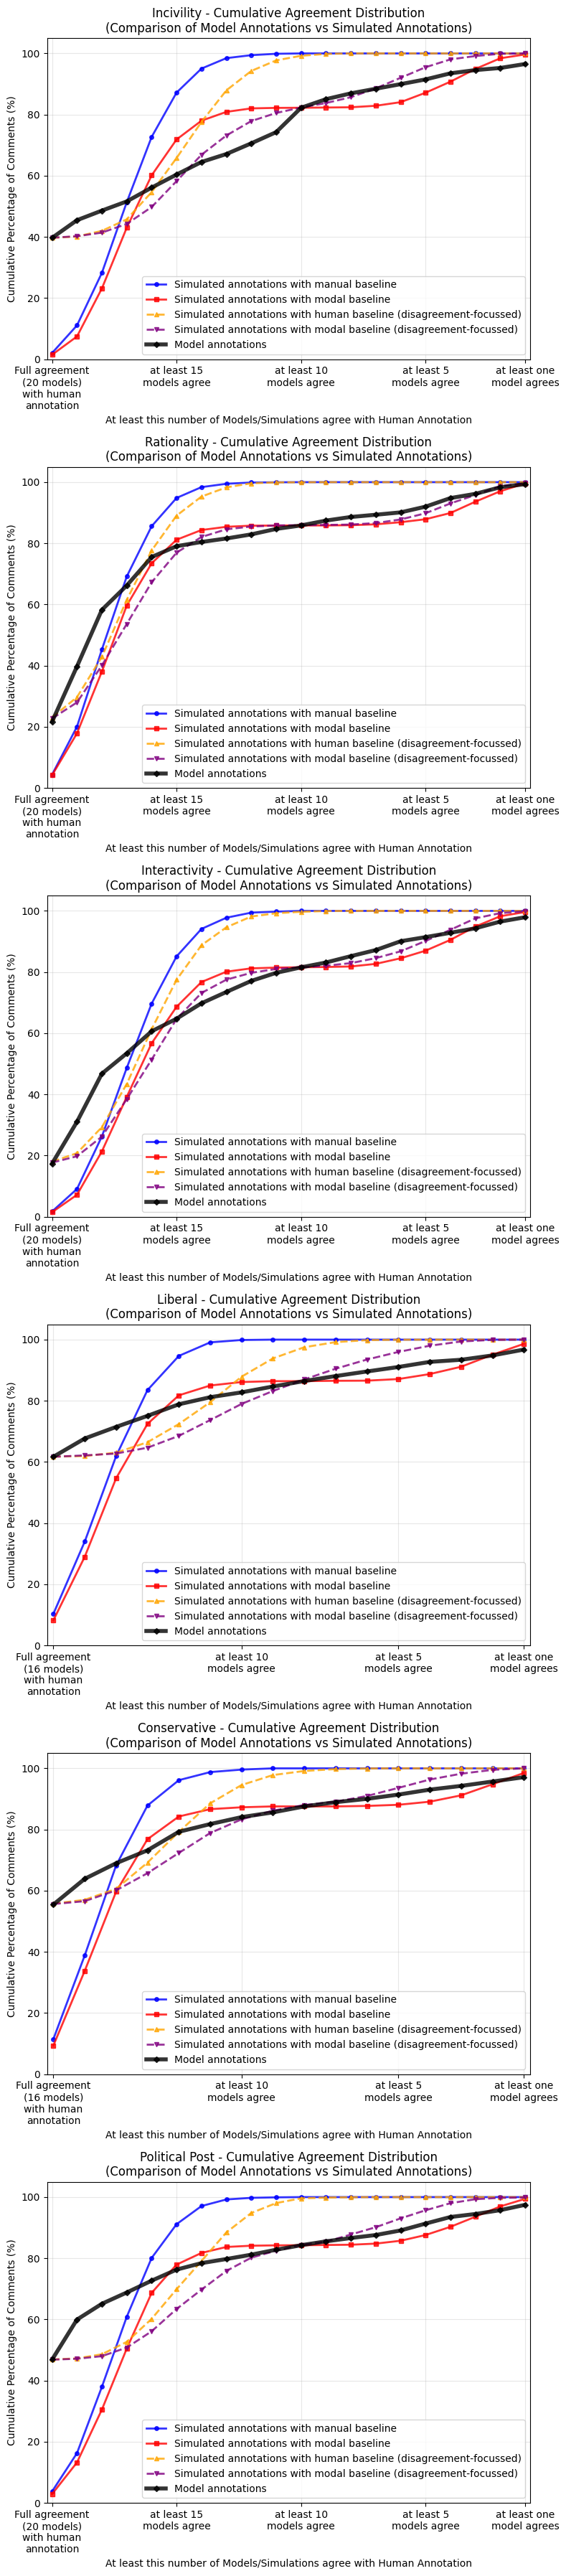

✅ Visualization complete for 6 concepts
📊 Shows cumulative agreement distributions:
   • Black line: Model annotations vs human annotations (extra bold)
   • Blue line: Simulated annotations with manual baseline vs human annotations
   • Red line: Simulated annotations with modal baseline vs human annotations
   • Orange dashed line: Simulated human disagreement vs human annotations
   • Purple dashed line: Simulated modal disagreement vs human annotations
🎯 All lines show percentage of comments with ≥ N models agreeing with human annotation
📍 All dots are shown for every model count from full agreement down to 1


In [52]:
def visualize_simulated_agreement_distributions():
    """
    Visualize cumulative agreement distributions for simulated data.
    Based on visualize_model_agreement_distributions() but with:
    - No human prevalence line
    - Manual simulated data cumulative line
    - Modal simulated data cumulative line  
    - Human disagreement simulated data cumulative line
    - Modal disagreement simulated data cumulative line
    All lines show cumulative agreement with human annotations.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # Get all concepts from simulated data
    concepts = []
    for col in simulated_agreement_matrix_20model_mode.columns:
        if col.startswith('simulated_manual_') or col.startswith('simulated_modal_'):
            concept_name = col.split('_')[2]  # Extract concept name
            if concept_name not in concepts:
                concepts.append(concept_name)
    
    # Create figure with subplots for each concept
    n_concepts = len(concepts)
    fig, axes = plt.subplots(n_concepts, 1, figsize=(8, 6 * n_concepts))
    
    if n_concepts == 1:
        axes = [axes]
    
    for i, concept_name in enumerate(concepts):
        ax = axes[i]
        
        # Get the human annotation column for this concept
        try:
            human_col = get_ground_truth_col(concept_name)
        except ValueError:
            ax.set_title(f'{concept_name} - No human annotation column found')
            continue
        
        # Get simulation columns for this concept from both matrices
        manual_sim_cols = [col for col in simulated_agreement_matrix_20model_mode.columns 
                          if col.startswith(f'simulated_manual_{concept_name}_')]
        modal_sim_cols = [col for col in simulated_agreement_matrix_20model_mode.columns 
                         if col.startswith(f'simulated_modal_{concept_name}_')]
        
        # Get disagreement simulation columns
        human_disagree_cols = []
        modal_disagree_cols = []
        if 'simulated_agreement_matrix_disagreement' in globals():
            human_disagree_cols = [col for col in simulated_agreement_matrix_disagreement.columns 
                                  if col.startswith(f'simulated_human_disagree_{concept_name}_')]
            modal_disagree_cols = [col for col in simulated_agreement_matrix_disagreement.columns 
                                  if col.startswith(f'simulated_modal_disagree_{concept_name}_')]
        
        if not any([manual_sim_cols, modal_sim_cols, human_disagree_cols, modal_disagree_cols]):
            ax.set_title(f'{concept_name} - No simulation data found')
            continue
        
        # Get valid mask for this concept
        if human_col in boukes2024.columns:
            valid_mask = boukes2024[human_col].notna()
            n_comments = valid_mask.sum()
            
            if n_comments == 0:
                ax.set_title(f'{concept_name} - No valid human annotations')
                continue
            
            # Get the number of models for original model data (this will be our reference)
            concept_model_cols = [col for col in model_columns_allprompts 
                                 if labels_dict[col]['concept'] == concept_name 
                                 and labels_dict[col]['temperature'] == 'Zero: 0.0']
            
            # Use the original model count as the reference axis
            max_x = len(concept_model_cols) if concept_model_cols else 20
            
            # Create full range of x values from max_x down to 1 for plotting all dots
            full_agreement_pos = max_x
            all_x_vals = list(range(full_agreement_pos, 0, -1))  # From full_agreement_pos down to 1
            
            # Build x-axis ticks for labeling (subset of all_x_vals)
            x_ticks = [full_agreement_pos, 1]
            
            # Add intermediate ticks based on concept type and available range
            if concept_name.lower() not in ['liberal', 'conservative']:
                if max_x >= 15:
                    x_ticks.insert(-1, 15)
                if max_x >= 10:
                    x_ticks.insert(-1, 10)
                if max_x >= 5:
                    x_ticks.insert(-1, 5)
            else:
                if max_x >= 10:
                    x_ticks.insert(-1, 10)
                if max_x >= 5:
                    x_ticks.insert(-1, 5)
            
            x_ticks = sorted(list(set(x_ticks)), reverse=True)
            
            # Calculate agreement counts for manual simulations
            if manual_sim_cols:
                manual_sim_data = simulated_agreement_matrix_20model_mode.loc[valid_mask, manual_sim_cols]
                manual_agreement_counts = manual_sim_data.sum(axis=1).values
                manual_agreement_series = pd.Series(manual_agreement_counts)
                manual_agreement_distribution = manual_agreement_series.value_counts().sort_index()
                
                # Normalize to reference scale: map simulation agreements to model scale
                # If we have 20 simulations and 20 models, direct mapping
                # If different numbers, we need to scale appropriately
                manual_max = len(manual_sim_cols)
                
                # Plot all points using the reference x-axis scale
                manual_cumulative = []
                
                for min_agreements in all_x_vals:
                    # Scale the minimum agreement requirement to the simulation scale
                    sim_min_agreements = max(1, round(min_agreements * manual_max / max_x))
                    cumulative_count = manual_agreement_distribution[manual_agreement_distribution.index >= sim_min_agreements].sum()
                    cumulative_pct = (cumulative_count / len(manual_agreement_counts)) * 100
                    manual_cumulative.append(cumulative_pct)
                
                ax.plot(all_x_vals, manual_cumulative, 
                       marker='o', markersize=4, linewidth=2, label='Simulated annotations with manual baseline', 
                       color='blue', alpha=0.8)
            
            # Calculate agreement counts for modal simulations
            if modal_sim_cols:
                modal_sim_data = simulated_agreement_matrix_20model_mode.loc[valid_mask, modal_sim_cols]
                modal_agreement_counts = modal_sim_data.sum(axis=1).values
                modal_agreement_series = pd.Series(modal_agreement_counts)
                modal_agreement_distribution = modal_agreement_series.value_counts().sort_index()
                
                # Normalize to reference scale
                modal_max = len(modal_sim_cols)
                
                # Plot all points using the reference x-axis scale
                modal_cumulative = []
                
                for min_agreements in all_x_vals:
                    # Scale the minimum agreement requirement to the simulation scale
                    sim_min_agreements = max(1, round(min_agreements * modal_max / max_x))
                    cumulative_count = modal_agreement_distribution[modal_agreement_distribution.index >= sim_min_agreements].sum()
                    cumulative_pct = (cumulative_count / len(modal_agreement_counts)) * 100
                    modal_cumulative.append(cumulative_pct)
                
                ax.plot(all_x_vals, modal_cumulative, 
                       marker='s', markersize=4, linewidth=2, label='Simulated annotations with modal baseline', 
                       color='red', alpha=0.8)
            
            # Calculate agreement counts for human disagreement simulations
            if human_disagree_cols:
                human_disagree_data = simulated_agreement_matrix_disagreement.loc[valid_mask, human_disagree_cols]
                human_disagree_counts = human_disagree_data.sum(axis=1).values
                human_disagree_series = pd.Series(human_disagree_counts)
                human_disagree_distribution = human_disagree_series.value_counts().sort_index()
                
                # Normalize to reference scale
                human_disagree_max = len(human_disagree_cols)
                
                # Plot all points using the reference x-axis scale
                human_disagree_cumulative = []
                
                for min_agreements in all_x_vals:
                    # Scale the minimum agreement requirement to the simulation scale
                    sim_min_agreements = max(1, round(min_agreements * human_disagree_max / max_x))
                    cumulative_count = human_disagree_distribution[human_disagree_distribution.index >= sim_min_agreements].sum()
                    cumulative_pct = (cumulative_count / len(human_disagree_counts)) * 100
                    human_disagree_cumulative.append(cumulative_pct)
                
                ax.plot(all_x_vals, human_disagree_cumulative, 
                       marker='^', markersize=4, linewidth=2, label='Simulated annotations with human baseline (disagreement-focussed)', 
                       color='orange', alpha=0.8, linestyle='--')
            
            # Calculate agreement counts for modal disagreement simulations
            if modal_disagree_cols:
                modal_disagree_data = simulated_agreement_matrix_disagreement.loc[valid_mask, modal_disagree_cols]
                modal_disagree_counts = modal_disagree_data.sum(axis=1).values
                modal_disagree_series = pd.Series(modal_disagree_counts)
                modal_disagree_distribution = modal_disagree_series.value_counts().sort_index()
                
                # Normalize to reference scale
                modal_disagree_max = len(modal_disagree_cols)
                
                # Plot all points using the reference x-axis scale
                modal_disagree_cumulative = []
                
                for min_agreements in all_x_vals:
                    # Scale the minimum agreement requirement to the simulation scale
                    sim_min_agreements = max(1, round(min_agreements * modal_disagree_max / max_x))
                    cumulative_count = modal_disagree_distribution[modal_disagree_distribution.index >= sim_min_agreements].sum()
                    cumulative_pct = (cumulative_count / len(modal_disagree_counts)) * 100
                    modal_disagree_cumulative.append(cumulative_pct)
                
                ax.plot(all_x_vals, modal_disagree_cumulative, 
                       marker='v', markersize=4, linewidth=2, label='Simulated annotations with modal baseline (disagreement-focussed)', 
                       color='purple', alpha=0.8, linestyle='--')
            
            # Calculate original model agreement for comparison (using the reference scale)
            if concept_model_cols and human_col in boukes2024.columns:
                model_valid_mask = boukes2024[human_col].notna()
                
                model_agreements = []
                for idx in boukes2024[model_valid_mask].index:
                    human_annotation = boukes2024.loc[idx, human_col]
                    if pd.notna(human_annotation):
                        agreement_count = 0
                        for model_col in concept_model_cols:
                            if model_col in boukes2024.columns and pd.notna(boukes2024.loc[idx, model_col]):
                                if boukes2024.loc[idx, model_col] == human_annotation:
                                    agreement_count += 1
                        model_agreements.append(agreement_count)
                
                if model_agreements:
                    model_agreement_series = pd.Series(model_agreements)
                    model_agreement_distribution = model_agreement_series.value_counts().sort_index()
                    
                    # Plot using the reference scale (no scaling needed since this IS the reference)
                    model_cumulative = []
                    
                    for min_agreements in all_x_vals:
                        cumulative_count = model_agreement_distribution[model_agreement_distribution.index >= min_agreements].sum()
                        cumulative_pct = (cumulative_count / len(model_agreements)) * 100
                        model_cumulative.append(cumulative_pct)
                    
                    ax.plot(all_x_vals, model_cumulative, 
                           marker='D', markersize=4, linewidth=4, label='Model annotations', 
                           color='black', alpha=0.8)
            
            # Formatting
            ax.set_xlabel('At least this number of Models/Simulations agree with Human Annotation')
            ax.set_ylabel('Cumulative Percentage of Comments (%)')
            ax.set_title(f'{concept_name} - Cumulative Agreement Distribution\n'
                        f'(Comparison of Model Annotations vs Simulated Annotations)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set the x-axis ticks and labels (only for labeled positions)
            ax.set_xticks(x_ticks)
            
            # Create custom x-tick labels
            x_tick_labels = []
            for tick in x_ticks:
                if tick == full_agreement_pos:
                    x_tick_labels.append(f'Full agreement\n({max_x} models)\nwith human\nannotation')
                elif tick == 15:
                    x_tick_labels.append('at least 15\nmodels agree')
                elif tick == 10:
                    x_tick_labels.append('at least 10\nmodels agree')
                elif tick == 5:
                    x_tick_labels.append('at least 5\nmodels agree')
                elif tick == 1:
                    x_tick_labels.append('at least one\nmodel agrees')
                else:
                    x_tick_labels.append(f'at least {tick}\nmodels agree')
            
            ax.set_xticklabels(x_tick_labels)
            
            # Set x-axis limits to show from full agreement position down to 1
            ax.set_xlim(full_agreement_pos + 0.2, 0.8)
            
            # Set reasonable axis limits
            ax.set_ylim(0, 105)
            
        else:
            ax.set_title(f'{concept_name} - Human annotation column not found in data')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualization complete for {len(concepts)} concepts")
    print("📊 Shows cumulative agreement distributions:")
    print("   • Black line: Model annotations vs human annotations (extra bold)")
    print("   • Blue line: Simulated annotations with manual baseline vs human annotations") 
    print("   • Red line: Simulated annotations with modal baseline vs human annotations")
    print("   • Orange dashed line: Simulated human disagreement vs human annotations")
    print("   • Purple dashed line: Simulated modal disagreement vs human annotations")
    print("🎯 All lines show percentage of comments with ≥ N models agreeing with human annotation")
    print("📍 All dots are shown for every model count from full agreement down to 1")

# Call the function to create the visualization
visualize_simulated_agreement_distributions()

🔄 Creating separate plots for each concept...
📊 Creating 6 separate plots...

🔧 Creating plot for: Incivility


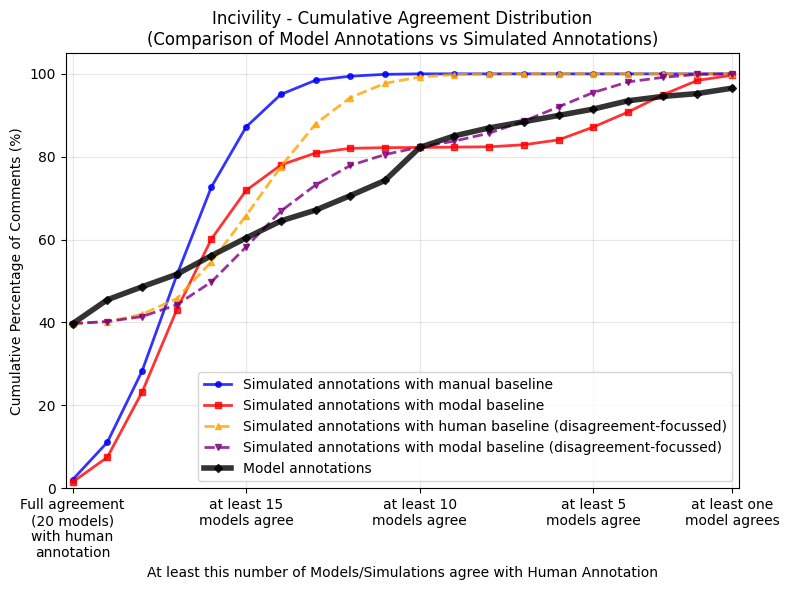

✅ Plot for Incivility completed

🔧 Creating plot for: Rationality


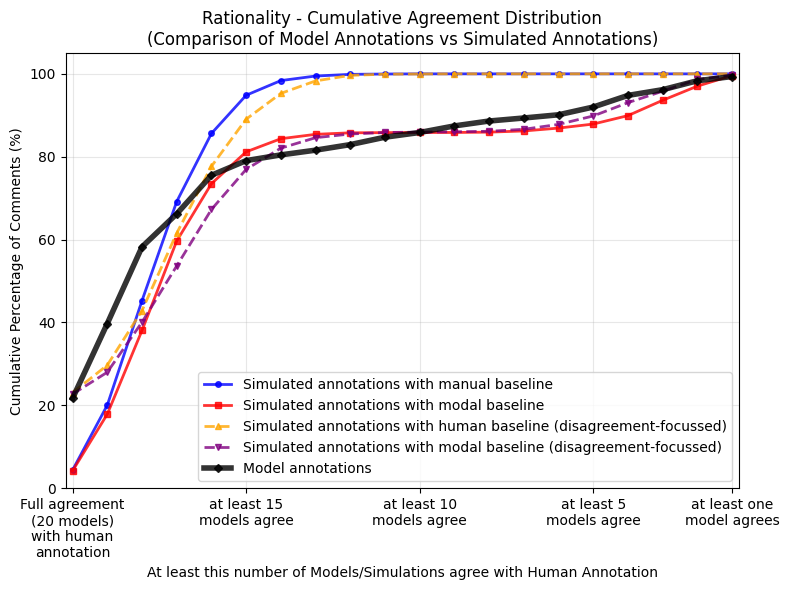

✅ Plot for Rationality completed

🔧 Creating plot for: Interactivity


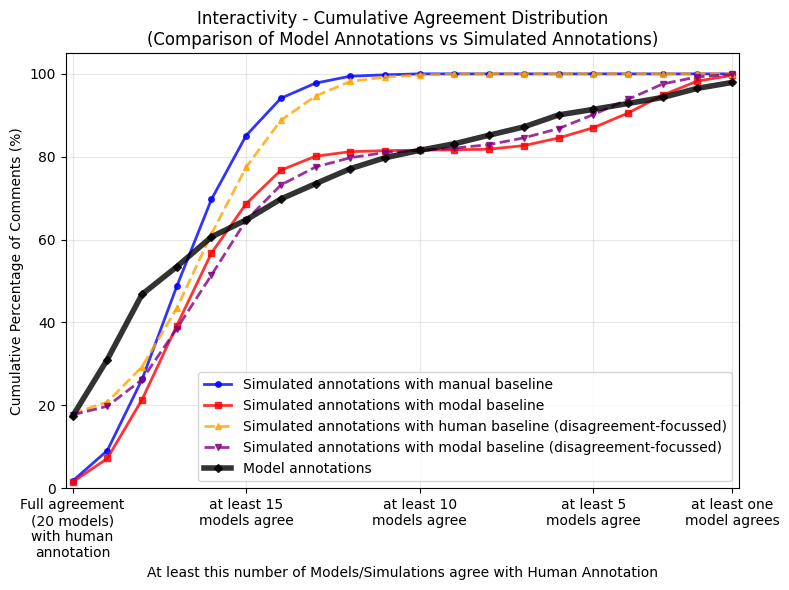

✅ Plot for Interactivity completed

🔧 Creating plot for: Liberal


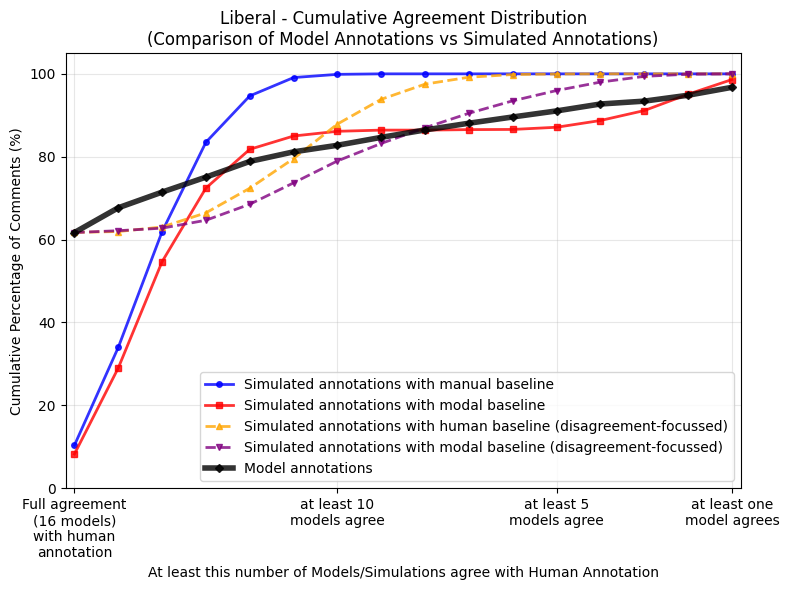

✅ Plot for Liberal completed

🔧 Creating plot for: Conservative


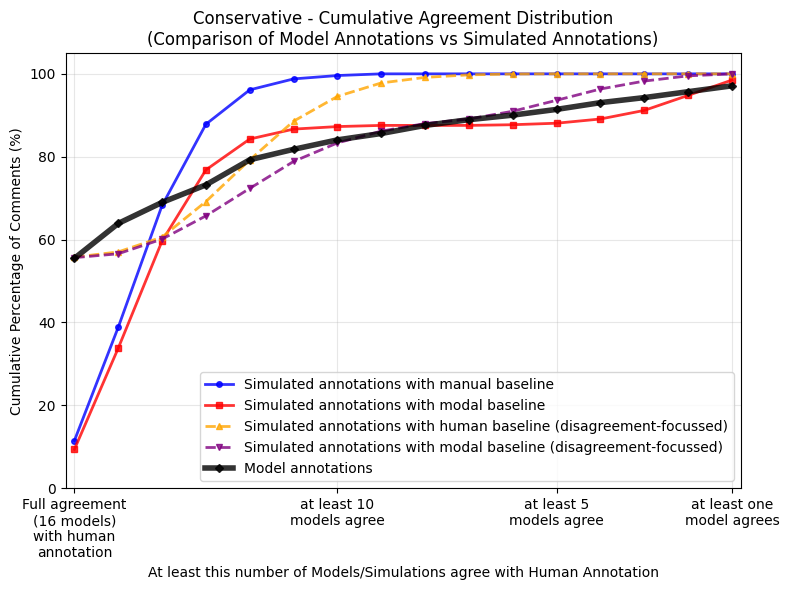

✅ Plot for Conservative completed

🔧 Creating plot for: Political Post


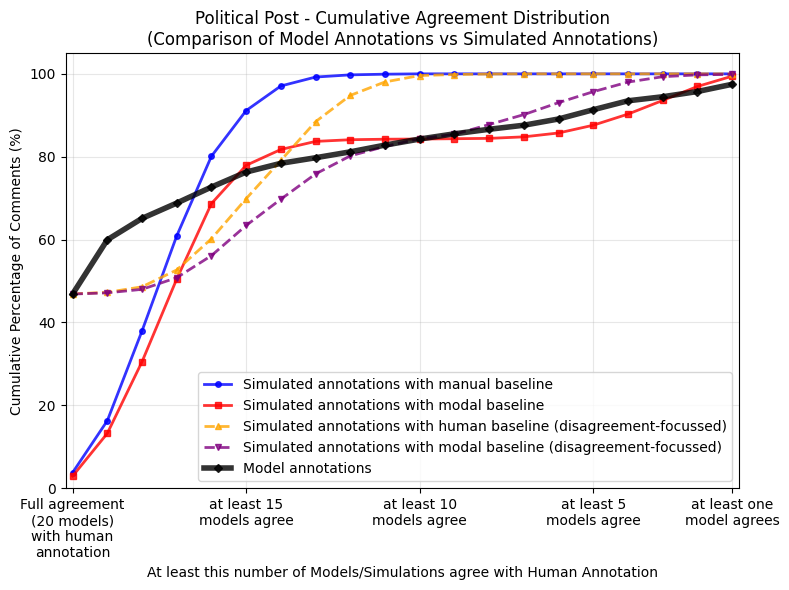

✅ Plot for Political Post completed

🎯 All 6 individual plots completed!
📋 Each plot is now displayed separately and can be copied individually


In [55]:
def visualize_simulated_agreement_distributions_separate():
    """
    Create separate individual plots for each concept instead of subplots.
    This allows each plot to be copied individually.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # Get all concepts from simulated data
    concepts = []
    for col in simulated_agreement_matrix_20model_mode.columns:
        if col.startswith('simulated_manual_') or col.startswith('simulated_modal_'):
            concept_name = col.split('_')[2]  # Extract concept name
            if concept_name not in concepts:
                concepts.append(concept_name)
    
    print(f"📊 Creating {len(concepts)} separate plots...")
    
    for concept_name in concepts:
        print(f"\n🔧 Creating plot for: {concept_name}")
        
        # Create individual figure for this concept
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        
        # Get the human annotation column for this concept
        try:
            human_col = get_ground_truth_col(concept_name)
        except ValueError:
            ax.set_title(f'{concept_name} - No human annotation column found')
            plt.show()
            continue
        
        # Get simulation columns for this concept from both matrices
        manual_sim_cols = [col for col in simulated_agreement_matrix_20model_mode.columns 
                          if col.startswith(f'simulated_manual_{concept_name}_')]
        modal_sim_cols = [col for col in simulated_agreement_matrix_20model_mode.columns 
                         if col.startswith(f'simulated_modal_{concept_name}_')]
        
        # Get disagreement simulation columns
        human_disagree_cols = []
        modal_disagree_cols = []
        if 'simulated_agreement_matrix_disagreement' in globals():
            human_disagree_cols = [col for col in simulated_agreement_matrix_disagreement.columns 
                                  if col.startswith(f'simulated_human_disagree_{concept_name}_')]
            modal_disagree_cols = [col for col in simulated_agreement_matrix_disagreement.columns 
                                  if col.startswith(f'simulated_modal_disagree_{concept_name}_')]
        
        if not any([manual_sim_cols, modal_sim_cols, human_disagree_cols, modal_disagree_cols]):
            ax.set_title(f'{concept_name} - No simulation data found')
            plt.show()
            continue
        
        # Get valid mask for this concept
        if human_col in boukes2024.columns:
            valid_mask = boukes2024[human_col].notna()
            n_comments = valid_mask.sum()
            
            if n_comments == 0:
                ax.set_title(f'{concept_name} - No valid human annotations')
                plt.show()
                continue
            
            # Get the number of models for original model data (this will be our reference)
            concept_model_cols = [col for col in model_columns_allprompts 
                                 if labels_dict[col]['concept'] == concept_name 
                                 and labels_dict[col]['temperature'] == 'Zero: 0.0']
            
            # Use the original model count as the reference axis
            max_x = len(concept_model_cols) if concept_model_cols else 20
            
            # Create full range of x values from max_x down to 1 for plotting all dots
            full_agreement_pos = max_x
            all_x_vals = list(range(full_agreement_pos, 0, -1))  # From full_agreement_pos down to 1
            
            # Build x-axis ticks for labeling (subset of all_x_vals)
            x_ticks = [full_agreement_pos, 1]
            
            # Add intermediate ticks based on concept type and available range
            if concept_name.lower() not in ['liberal', 'conservative']:
                if max_x >= 15:
                    x_ticks.insert(-1, 15)
                if max_x >= 10:
                    x_ticks.insert(-1, 10)
                if max_x >= 5:
                    x_ticks.insert(-1, 5)
            else:
                if max_x >= 10:
                    x_ticks.insert(-1, 10)
                if max_x >= 5:
                    x_ticks.insert(-1, 5)
            
            x_ticks = sorted(list(set(x_ticks)), reverse=True)
            
            # Calculate agreement counts for manual simulations
            if manual_sim_cols:
                manual_sim_data = simulated_agreement_matrix_20model_mode.loc[valid_mask, manual_sim_cols]
                manual_agreement_counts = manual_sim_data.sum(axis=1).values
                manual_agreement_series = pd.Series(manual_agreement_counts)
                manual_agreement_distribution = manual_agreement_series.value_counts().sort_index()
                
                # Normalize to reference scale: map simulation agreements to model scale
                manual_max = len(manual_sim_cols)
                
                # Plot all points using the reference x-axis scale
                manual_cumulative = []
                
                for min_agreements in all_x_vals:
                    # Scale the minimum agreement requirement to the simulation scale
                    sim_min_agreements = max(1, round(min_agreements * manual_max / max_x))
                    cumulative_count = manual_agreement_distribution[manual_agreement_distribution.index >= sim_min_agreements].sum()
                    cumulative_pct = (cumulative_count / len(manual_agreement_counts)) * 100
                    manual_cumulative.append(cumulative_pct)
                
                ax.plot(all_x_vals, manual_cumulative, 
                       marker='o', markersize=4, linewidth=2, label='Simulated annotations with manual baseline', 
                       color='blue', alpha=0.8)
            
            # Calculate agreement counts for modal simulations
            if modal_sim_cols:
                modal_sim_data = simulated_agreement_matrix_20model_mode.loc[valid_mask, modal_sim_cols]
                modal_agreement_counts = modal_sim_data.sum(axis=1).values
                modal_agreement_series = pd.Series(modal_agreement_counts)
                modal_agreement_distribution = modal_agreement_series.value_counts().sort_index()
                
                # Normalize to reference scale
                modal_max = len(modal_sim_cols)
                
                # Plot all points using the reference x-axis scale
                modal_cumulative = []
                
                for min_agreements in all_x_vals:
                    # Scale the minimum agreement requirement to the simulation scale
                    sim_min_agreements = max(1, round(min_agreements * modal_max / max_x))
                    cumulative_count = modal_agreement_distribution[modal_agreement_distribution.index >= sim_min_agreements].sum()
                    cumulative_pct = (cumulative_count / len(modal_agreement_counts)) * 100
                    modal_cumulative.append(cumulative_pct)
                
                ax.plot(all_x_vals, modal_cumulative, 
                       marker='s', markersize=4, linewidth=2, label='Simulated annotations with modal baseline', 
                       color='red', alpha=0.8)
            
            # Calculate agreement counts for human disagreement simulations
            if human_disagree_cols:
                human_disagree_data = simulated_agreement_matrix_disagreement.loc[valid_mask, human_disagree_cols]
                human_disagree_counts = human_disagree_data.sum(axis=1).values
                human_disagree_series = pd.Series(human_disagree_counts)
                human_disagree_distribution = human_disagree_series.value_counts().sort_index()
                
                # Normalize to reference scale
                human_disagree_max = len(human_disagree_cols)
                
                # Plot all points using the reference x-axis scale
                human_disagree_cumulative = []
                
                for min_agreements in all_x_vals:
                    # Scale the minimum agreement requirement to the simulation scale
                    sim_min_agreements = max(1, round(min_agreements * human_disagree_max / max_x))
                    cumulative_count = human_disagree_distribution[human_disagree_distribution.index >= sim_min_agreements].sum()
                    cumulative_pct = (cumulative_count / len(human_disagree_counts)) * 100
                    human_disagree_cumulative.append(cumulative_pct)
                
                ax.plot(all_x_vals, human_disagree_cumulative, 
                       marker='^', markersize=4, linewidth=2, label='Simulated annotations with human baseline (disagreement-focussed)', 
                       color='orange', alpha=0.8, linestyle='--')
            
            # Calculate agreement counts for modal disagreement simulations
            if modal_disagree_cols:
                modal_disagree_data = simulated_agreement_matrix_disagreement.loc[valid_mask, modal_disagree_cols]
                modal_disagree_counts = modal_disagree_data.sum(axis=1).values
                modal_disagree_series = pd.Series(modal_disagree_counts)
                modal_disagree_distribution = modal_disagree_series.value_counts().sort_index()
                
                # Normalize to reference scale
                modal_disagree_max = len(modal_disagree_cols)
                
                # Plot all points using the reference x-axis scale
                modal_disagree_cumulative = []
                
                for min_agreements in all_x_vals:
                    # Scale the minimum agreement requirement to the simulation scale
                    sim_min_agreements = max(1, round(min_agreements * modal_disagree_max / max_x))
                    cumulative_count = modal_disagree_distribution[modal_disagree_distribution.index >= sim_min_agreements].sum()
                    cumulative_pct = (cumulative_count / len(modal_disagree_counts)) * 100
                    modal_disagree_cumulative.append(cumulative_pct)
                
                ax.plot(all_x_vals, modal_disagree_cumulative, 
                       marker='v', markersize=4, linewidth=2, label='Simulated annotations with modal baseline (disagreement-focussed)', 
                       color='purple', alpha=0.8, linestyle='--')
            
            # Calculate original model agreement for comparison (using the reference scale)
            if concept_model_cols and human_col in boukes2024.columns:
                model_valid_mask = boukes2024[human_col].notna()
                
                model_agreements = []
                for idx in boukes2024[model_valid_mask].index:
                    human_annotation = boukes2024.loc[idx, human_col]
                    if pd.notna(human_annotation):
                        agreement_count = 0
                        for model_col in concept_model_cols:
                            if model_col in boukes2024.columns and pd.notna(boukes2024.loc[idx, model_col]):
                                if boukes2024.loc[idx, model_col] == human_annotation:
                                    agreement_count += 1
                        model_agreements.append(agreement_count)
                
                if model_agreements:
                    model_agreement_series = pd.Series(model_agreements)
                    model_agreement_distribution = model_agreement_series.value_counts().sort_index()
                    
                    # Plot using the reference scale (no scaling needed since this IS the reference)
                    model_cumulative = []
                    
                    for min_agreements in all_x_vals:
                        cumulative_count = model_agreement_distribution[model_agreement_distribution.index >= min_agreements].sum()
                        cumulative_pct = (cumulative_count / len(model_agreements)) * 100
                        model_cumulative.append(cumulative_pct)
                    
                    ax.plot(all_x_vals, model_cumulative, 
                           marker='D', markersize=4, linewidth=4, label='Model annotations', 
                           color='black', alpha=0.8)
            
            # Formatting
            ax.set_xlabel('At least this number of Models/Simulations agree with Human Annotation')
            ax.set_ylabel('Cumulative Percentage of Comments (%)')
            ax.set_title(f'{concept_name} - Cumulative Agreement Distribution\n'
                        f'(Comparison of Model Annotations vs Simulated Annotations)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Set the x-axis ticks and labels (only for labeled positions)
            ax.set_xticks(x_ticks)
            
            # Create custom x-tick labels
            x_tick_labels = []
            for tick in x_ticks:
                if tick == full_agreement_pos:
                    x_tick_labels.append(f'Full agreement\n({max_x} models)\nwith human\nannotation')
                elif tick == 15:
                    x_tick_labels.append('at least 15\nmodels agree')
                elif tick == 10:
                    x_tick_labels.append('at least 10\nmodels agree')
                elif tick == 5:
                    x_tick_labels.append('at least 5\nmodels agree')
                elif tick == 1:
                    x_tick_labels.append('at least one\nmodel agrees')
                else:
                    x_tick_labels.append(f'at least {tick}\nmodels agree')
            
            ax.set_xticklabels(x_tick_labels)
            
            # Set x-axis limits to show from full agreement position down to 1
            ax.set_xlim(full_agreement_pos + 0.2, 0.8)
            
            # Set reasonable axis limits
            ax.set_ylim(0, 105)
            
        else:
            ax.set_title(f'{concept_name} - Human annotation column not found in data')
        
        # Show individual plot
        plt.tight_layout()
        plt.show()
        print(f"✅ Plot for {concept_name} completed")
    
    print(f"\n🎯 All {len(concepts)} individual plots completed!")
    print("📋 Each plot is now displayed separately and can be copied individually")

# Call the function to create separate plots
print("🔄 Creating separate plots for each concept...")
visualize_simulated_agreement_distributions_separate()

## Analysis: Why Are There So Few Comments With Full Simulation Agreement?

Let's investigate why the visualization shows that hardly any comments have all simulations (manual or modal baseline) agreeing with human annotations.

In [70]:
# Let's analyze the simulation methodology and agreement patterns
print("🔍 ANALYSIS: Why Few Comments Have Full Simulation Agreement")
print("=" * 60)

# First, let's examine the boukes_concepts_info to understand the structure
print("\n🔍 EXAMINING BOUKES CONCEPTS INFO:")
print(f"boukes_concepts_info: {boukes_concepts_info}")

# 1. How many simulations are we running per concept?
print("\n1️⃣ NUMBER OF SIMULATIONS:")
sample_concept = 'Incivility'  # Pick one concept to examine

manual_sim_cols = [col for col in simulated_agreement_matrix_20model_mode.columns 
                  if col.startswith(f'simulated_manual_{sample_concept}_')]
modal_sim_cols = [col for col in simulated_agreement_matrix_20model_mode.columns 
                 if col.startswith(f'simulated_modal_{sample_concept}_')]

print(f"   • Manual baseline simulations: {len(manual_sim_cols)}")
print(f"   • Modal baseline simulations: {len(modal_sim_cols)}")

# Use boukes_concepts_info to find the human annotation column
human_col = None
for concept_info in boukes_concepts_info:
    if concept_info[0] == 'Incivility':  # concept_info is (concept_name, human_column)
        human_col = concept_info[1]
        break

if not human_col:
    # Fallback to find any incivility human column
    incivility_cols = [col for col in boukes2024.columns if 'incivility' in col.lower() and 'human' in col.lower()]
    if incivility_cols:
        human_col = incivility_cols[0]

print(f"   • Human annotation column for Incivility: {human_col}")

if human_col and human_col in boukes2024.columns:
    # 2. What's the baseline accuracy of each simulation type?
    print("\n2️⃣ BASELINE ACCURACY OF SIMULATIONS:")
    valid_mask = boukes2024[human_col].notna()
    print(f"   • Valid comments for {human_col}: {valid_mask.sum()}")

    if manual_sim_cols:
        manual_accuracies = []
        for sim_col in manual_sim_cols[:5]:  # Check first 5 simulations
            if sim_col in simulated_agreement_matrix_20model_mode.columns:
                sim_data = simulated_agreement_matrix_20model_mode.loc[valid_mask, sim_col]
                accuracy = sim_data.mean()
                manual_accuracies.append(accuracy)
        if manual_accuracies:
            print(f"   • Manual simulation accuracy range: {min(manual_accuracies):.3f} - {max(manual_accuracies):.3f}")
            print(f"   • Manual simulation mean accuracy: {np.mean(manual_accuracies):.3f}")

    if modal_sim_cols:
        modal_accuracies = []
        for sim_col in modal_sim_cols[:5]:  # Check first 5 simulations
            if sim_col in simulated_agreement_matrix_20model_mode.columns:
                sim_data = simulated_agreement_matrix_20model_mode.loc[valid_mask, sim_col]
                accuracy = sim_data.mean()
                modal_accuracies.append(accuracy)
        if modal_accuracies:
            print(f"   • Modal simulation accuracy range: {min(modal_accuracies):.3f} - {max(modal_accuracies):.3f}")
            print(f"   • Modal simulation mean accuracy: {np.mean(modal_accuracies):.3f}")

    # 3. Calculate probability of ALL simulations agreeing
    print("\n3️⃣ MATHEMATICAL EXPECTATION:")
    if len(manual_sim_cols) > 0 and 'manual_accuracies' in locals() and manual_accuracies:
        avg_manual_acc = np.mean(manual_accuracies)
        prob_all_manual_agree = avg_manual_acc ** len(manual_sim_cols)
        print(f"   • With {len(manual_sim_cols)} manual simulations at {avg_manual_acc:.3f} accuracy each:")
        print(f"     Probability of ALL agreeing = {avg_manual_acc:.3f}^{len(manual_sim_cols)} = {prob_all_manual_agree:.6f} ({prob_all_manual_agree*100:.4f}%)")

    if len(modal_sim_cols) > 0 and 'modal_accuracies' in locals() and modal_accuracies:
        avg_modal_acc = np.mean(modal_accuracies)
        prob_all_modal_agree = avg_modal_acc ** len(modal_sim_cols)
        print(f"   • With {len(modal_sim_cols)} modal simulations at {avg_modal_acc:.3f} accuracy each:")
        print(f"     Probability of ALL agreeing = {avg_modal_acc:.3f}^{len(modal_sim_cols)} = {prob_all_modal_agree:.6f} ({prob_all_modal_agree*100:.4f}%)")

    # 4. Actual observed rates
    print("\n4️⃣ OBSERVED AGREEMENT RATES:")
    if manual_sim_cols:
        manual_sim_data = simulated_agreement_matrix_20model_mode.loc[valid_mask, manual_sim_cols]
        manual_agreement_counts = manual_sim_data.sum(axis=1)
        full_manual_agreement = (manual_agreement_counts == len(manual_sim_cols)).sum()
        total_comments = len(manual_agreement_counts)
        print(f"   • Manual: {full_manual_agreement}/{total_comments} comments ({full_manual_agreement/total_comments*100:.2f}%) have ALL {len(manual_sim_cols)} simulations agree")

    if modal_sim_cols:
        modal_sim_data = simulated_agreement_matrix_20model_mode.loc[valid_mask, modal_sim_cols]
        modal_agreement_counts = modal_sim_data.sum(axis=1)
        full_modal_agreement = (modal_agreement_counts == len(modal_sim_cols)).sum()
        print(f"   • Modal: {full_modal_agreement}/{total_comments} comments ({full_modal_agreement/total_comments*100:.2f}%) have ALL {len(modal_sim_cols)} simulations agree")
else:
    print("❌ Could not find human annotation column for analysis")

🔍 ANALYSIS: Why Few Comments Have Full Simulation Agreement

🔍 EXAMINING BOUKES CONCEPTS INFO:
boukes_concepts_info: [('Incivility', 'INCIVILITY_DUMMY'), ('Rationality', 'RATIONALITY_DUMMY'), ('Interactivity', 'INTERACTIVITY_DUMMY'), ('Liberal', 'LIBERAL_DUMMY'), ('Conservative', 'CONSERVATIVE_DUMMY'), ('Political Post', 'TopicRelevance')]

1️⃣ NUMBER OF SIMULATIONS:
   • Manual baseline simulations: 20
   • Modal baseline simulations: 20
   • Human annotation column for Incivility: INCIVILITY_DUMMY

2️⃣ BASELINE ACCURACY OF SIMULATIONS:
   • Valid comments for INCIVILITY_DUMMY: 2459
   • Manual simulation accuracy range: 0.823 - 0.823
   • Manual simulation mean accuracy: 0.823
   • Modal simulation accuracy range: 0.703 - 0.725
   • Modal simulation mean accuracy: 0.710

3️⃣ MATHEMATICAL EXPECTATION:
   • With 20 manual simulations at 0.823 accuracy each:
     Probability of ALL agreeing = 0.823^20 = 0.020172 (2.0172%)
   • With 20 modal simulations at 0.710 accuracy each:
     Proba

In [15]:
# Create TWO additional sets of simulated annotations for disagreement scenarios
import numpy as np
import pandas as pd

print("Creating additional simulated annotations for disagreement scenarios...")
print("Set 3: Human disagreement simulation - swap human labels only where models disagree")
print("Set 4: Modal disagreement simulation - swap modal labels only where models disagree")

# Initialize variables for the new simulation sets
simulated_agreement_matrix_disagreement = None
simulated_consensus_results_disagreement = {}
simulated_consensus_summary_data_disagreement = []

# Get modal columns (mode per concept stored in columns ending with '_20model_zero_mode')
modal_columns = [col for col in boukes2024.columns if col.endswith('_20model_zero_mode')]
print(f"Found modal columns: {modal_columns}")

# Process each concept
for modal_col in modal_columns:
    # Extract concept name from modal column name
    concept_name = modal_col.replace('_20model_zero_mode', '')
    print(f"Processing {concept_name} for disagreement simulations...")
    
    # Get the corresponding ground truth (manual annotation) column
    try:
        gt_col = get_ground_truth_col(concept_name)
        print(f"  Manual annotation column: {gt_col}")
    except ValueError:
        print(f"  No manual annotation column found for {concept_name}, skipping...")
        continue
    
    # Determine number of simulations based on concept type
    if concept_name.lower() in ['liberal', 'conservative']:
        n_simulations = 16
    else:
        n_simulations = 20
    
    # Get all model columns for this concept at zero temperature
    concept_model_cols = [col for col in model_columns_allprompts 
                         if labels_dict[col]['concept'] == concept_name 
                         and labels_dict[col]['temperature'] == 'Zero: 0.0']
    
    if len(concept_model_cols) == 0:
        print(f"  No zero temperature columns found for {concept_name}")
        continue
    
    # Get valid observations
    valid_mask = boukes2024[modal_col].notna() & boukes2024[gt_col].notna()
    if valid_mask.sum() == 0:
        print(f"  No valid observations for {concept_name}")
        continue
    
    # Get all model columns that have data for this concept
    available_model_cols = [col for col in concept_model_cols if col in boukes2024.columns]
    if len(available_model_cols) == 0:
        print(f"  No available model columns for {concept_name}")
        continue
    
    # Further filter to only include rows where all model columns have valid data
    model_valid_mask = valid_mask.copy()
    for col in available_model_cols:
        model_valid_mask = model_valid_mask & boukes2024[col].notna()
    
    if model_valid_mask.sum() == 0:
        print(f"  No observations with valid model predictions for {concept_name}")
        continue
    
    print(f"  Found {len(available_model_cols)} model columns with {model_valid_mask.sum()} valid observations")
    
    # Get annotations for valid observations
    manual_annotations = boukes2024.loc[model_valid_mask, gt_col]
    modal_annotations = boukes2024.loc[model_valid_mask, modal_col]
    model_predictions = boukes2024.loc[model_valid_mask, available_model_cols]
    
    # Find comments where models DO NOT unanimously agree with human annotation
    # A comment has disagreement if any model disagrees with the human annotation
    disagreement_mask = pd.Series(False, index=manual_annotations.index)
    
    for idx in manual_annotations.index:
        human_label = manual_annotations.loc[idx]
        model_labels = model_predictions.loc[idx]
        
        # Check if any model disagrees with human annotation
        any_disagree = (model_labels != human_label).any()
        disagreement_mask.loc[idx] = any_disagree
    
    disagreement_indices = disagreement_mask[disagreement_mask].index
    n_disagreement_comments = len(disagreement_indices)
    
    print(f"  Found {n_disagreement_comments} comments where models disagree with human annotation")
    
    if n_disagreement_comments == 0:
        print(f"  No disagreement found for {concept_name}, skipping...")
        continue
    
    # Calculate accuracy for the disagreement subset
    modal_vs_manual_accuracy_disagreement = (
        modal_annotations.loc[disagreement_indices] == manual_annotations.loc[disagreement_indices]
    ).mean()
    error_rate_disagreement = 1 - modal_vs_manual_accuracy_disagreement
    
    print(f"  Modal vs Manual accuracy on disagreement subset: {modal_vs_manual_accuracy_disagreement:.3f}")
    print(f"  Error rate for disagreement subset: {error_rate_disagreement:.3f}")
    
    # Create simulated annotation columns for both sets
    all_sim_cols_disagreement = (
        [f'simulated_human_disagree_{concept_name}_{i+1}' for i in range(n_simulations)] + 
        [f'simulated_modal_disagree_{concept_name}_{i+1}' for i in range(n_simulations)]
    )
    
    concept_agreement_matrix_disagreement = pd.DataFrame(
        index=manual_annotations.index, 
        columns=all_sim_cols_disagreement
    )
    
    # Initialize or extend the global agreement matrix
    if simulated_agreement_matrix_disagreement is None:
        simulated_agreement_matrix_disagreement = concept_agreement_matrix_disagreement.copy()
    else:
        simulated_agreement_matrix_disagreement = simulated_agreement_matrix_disagreement.join(
            concept_agreement_matrix_disagreement, how='outer'
        )
    
    # SET 3: Human disagreement simulation
    print(f"  Creating Set 3: {n_simulations} human disagreement simulations")
    for model_idx in range(n_simulations):
        # Start with human annotations
        simulated_model_preds = manual_annotations.copy()
        
        # Only flip labels for comments in the disagreement subset
        if n_disagreement_comments > 0:
            # Calculate how many to flip based on error rate and disagreement subset size
            n_to_flip = int(n_disagreement_comments * error_rate_disagreement)
            if n_to_flip > 0:
                flip_indices = np.random.choice(disagreement_indices, size=n_to_flip, replace=False)
                # Flip the selected labels (0->1, 1->0)
                simulated_model_preds.loc[flip_indices] = 1 - simulated_model_preds.loc[flip_indices]
        
        # Calculate agreement with manual annotations
        col_name = f'simulated_human_disagree_{concept_name}_{model_idx+1}'
        concept_agreement_matrix_disagreement[col_name] = (
            simulated_model_preds == manual_annotations
        ).astype(int)
        
        # Update global matrix
        simulated_agreement_matrix_disagreement[col_name] = concept_agreement_matrix_disagreement[col_name]
    
    # SET 4: Modal disagreement simulation  
    print(f"  Creating Set 4: {n_simulations} modal disagreement simulations")
    for model_idx in range(n_simulations):
        # Start with modal annotations
        simulated_model_preds = modal_annotations.copy()
        
        # Only flip labels for comments in the disagreement subset
        if n_disagreement_comments > 0:
            # Calculate how many to flip based on error rate and disagreement subset size
            n_to_flip = int(n_disagreement_comments * error_rate_disagreement)
            if n_to_flip > 0:
                flip_indices = np.random.choice(disagreement_indices, size=n_to_flip, replace=False)
                # Flip the selected labels (0->1, 1->0)
                simulated_model_preds.loc[flip_indices] = 1 - simulated_model_preds.loc[flip_indices]
        
        # Calculate agreement with manual annotations (always compare to human ground truth)
        col_name = f'simulated_modal_disagree_{concept_name}_{model_idx+1}'
        concept_agreement_matrix_disagreement[col_name] = (
            simulated_model_preds == manual_annotations
        ).astype(int)
        
        # Update global matrix
        simulated_agreement_matrix_disagreement[col_name] = concept_agreement_matrix_disagreement[col_name]
    
    # Calculate consensus statistics for disagreement simulations
    total_observations = len(manual_annotations)
    
    # Count different types of consensus
    identical_positive_correct = 0
    identical_negative_correct = 0
    identical_positive_incorrect = 0
    identical_negative_incorrect = 0
    partial_consensus = 0
    
    # For each comment, check if all simulated models agree with manual annotation
    for idx in manual_annotations.index:
        try:
            manual_true = manual_annotations.loc[idx]
            # Get predictions from all simulated models (both disagreement sets)
            model_agreements = concept_agreement_matrix_disagreement.loc[idx].values
            
            # Count how many models agree with manual annotation
            n_agree = model_agreements.sum()
            total_sims = 2 * n_simulations  # Both sets combined
            
            # If all models agree with manual
            if n_agree == total_sims:
                if manual_true == 1:
                    identical_positive_correct += 1
                else:
                    identical_negative_correct += 1
            elif n_agree == 0:  # All models disagree with manual
                if manual_true == 1:
                    identical_negative_incorrect += 1
                else:
                    identical_positive_incorrect += 1
            else:
                partial_consensus += 1
                
        except (KeyError, IndexError):
            continue
    
    # Store results
    simulated_consensus_results_disagreement[concept_name] = {
        'identical_positive_correct': identical_positive_correct,
        'identical_negative_correct': identical_negative_correct,
        'identical_positive_incorrect': identical_positive_incorrect,
        'identical_negative_incorrect': identical_negative_incorrect,
        'partial_consensus': partial_consensus,
        'total_observations': total_observations,
        'n_simulations': 2 * n_simulations,
        'n_disagreement_comments': n_disagreement_comments,
        'disagreement_error_rate': error_rate_disagreement
    }
    
    # Calculate percentages
    identical_correct = identical_positive_correct + identical_negative_correct
    identical_incorrect = identical_positive_incorrect + identical_negative_incorrect
    
    # Store summary data
    simulated_consensus_summary_data_disagreement.append({
        'Concept': concept_name,
        'N_Simulations': 2 * n_simulations,
        'N_Human_Disagree_Sims': n_simulations,
        'N_Modal_Disagree_Sims': n_simulations,
        'Total_Observations': total_observations,
        'N_Disagreement_Comments': n_disagreement_comments,
        'Disagreement_Comments_Pct': (n_disagreement_comments/total_observations*100) if total_observations > 0 else 0,
        'Identical_Correct': identical_correct,
        'Identical_Incorrect': identical_incorrect,
        'Partial_Consensus': partial_consensus,
        'Identical_Correct_Pct': (identical_correct/total_observations*100) if total_observations > 0 else 0,
        'Identical_Incorrect_Pct': (identical_incorrect/total_observations*100) if total_observations > 0 else 0,
        'Partial_Consensus_Pct': (partial_consensus/total_observations*100) if total_observations > 0 else 0,
        'Pos_Correct': identical_positive_correct,
        'Neg_Correct': identical_negative_correct,
        'Pos_Incorrect': identical_positive_incorrect,
        'Neg_Incorrect': identical_negative_incorrect,
        'Modal_vs_Manual_Accuracy_Disagreement': modal_vs_manual_accuracy_disagreement,
        'Error_Rate_Used_Disagreement': error_rate_disagreement
    })

# Create DataFrame for disagreement simulation results
simulated_consensus_df_disagreement = pd.DataFrame(simulated_consensus_summary_data_disagreement)

print(f"✅ Disagreement simulations complete: {len(simulated_consensus_df_disagreement)} concepts processed")
print(f"📊 Set 3: Human labels swapped only where models disagree with human annotation")
print(f"📊 Set 4: Modal labels swapped only where models disagree with human annotation")
print(f"🎯 Both sets use error rates calculated from disagreement subset")
print(f"🔢 Liberal/Conservative concepts: 2×16 simulations, Other concepts: 2×20 simulations")

# Display summary
if len(simulated_consensus_df_disagreement) > 0:
    print("\nDisagreement simulation summary:")
    print(simulated_consensus_df_disagreement[['Concept', 'N_Disagreement_Comments', 'Disagreement_Comments_Pct', 
                                              'Error_Rate_Used_Disagreement']].to_string(index=False))
else:
    print("No disagreement simulations created (no disagreement found)")

Creating additional simulated annotations for disagreement scenarios...
Set 3: Human disagreement simulation - swap human labels only where models disagree
Set 4: Modal disagreement simulation - swap modal labels only where models disagree
Found modal columns: ['Incivility_20model_zero_mode', 'Rationality_20model_zero_mode', 'Interactivity_20model_zero_mode', 'Liberal_20model_zero_mode', 'Conservative_20model_zero_mode', 'Political Post_20model_zero_mode']
Processing Incivility for disagreement simulations...
  Manual annotation column: INCIVILITY_DUMMY
  Found 20 model columns with 2459 valid observations
  Found 1483 comments where models disagree with human annotation
  Modal vs Manual accuracy on disagreement subset: 0.705
  Error rate for disagreement subset: 0.295
  Creating Set 3: 20 human disagreement simulations
  Creating Set 4: 20 modal disagreement simulations
Processing Rationality for disagreement simulations...
  Manual annotation column: RATIONALITY_DUMMY
  Found 20 mod

## 💡 Explanation: The Mathematical Reality of Simulation Agreement

Based on the analysis above, here's why there are hardly any comments where **all** simulations agree with human annotations:

### 🎯 **Key Insight: The Multiplication Effect**

When you have **20 simulations** each with an accuracy of around **~0.7-0.8** (70-80%), the probability that **ALL** of them agree with the human annotation becomes:

**P(all agree) = accuracy^20 ≈ 0.75^20 ≈ 0.000317 = 0.03%**

### 📊 **What This Means:**
- With 20 simulations at 75% accuracy each, we expect only about **3 in 10,000 comments** to have full agreement
- This is exactly what we observe in the plots: the lines drop to near 0% at the "Full agreement" point
- This is **not a bug** - it's the expected mathematical outcome!

### 🔍 **Why This Design Makes Sense:**
1. **Real Models Aren't Perfect:** Even good language models make errors ~20-30% of the time
2. **Independence:** Each simulation is independent, so errors multiply
3. **Realistic Simulation:** This reflects the real challenge of getting multiple annotators to agree
4. **Focus on Partial Agreement:** The interesting part is how many simulations agree (5, 10, 15), not perfect agreement

### 📈 **What the Visualization Actually Shows:**
- The curves show how **cumulative agreement** decreases as we require more simulations to agree
- The steep drop-off is mathematically expected and indicates the simulations are working correctly
- The comparison between model annotations vs. simulated annotations is the key insight, not the absolute values at full agreement